# DARLIN application (Fig 4): fate bias analysis

Hematopoiesis dataset from `Li, L., ..., S.-.W. Wang, F. Camargo, Cell 186, (2023)`.

The DARLIN lineage tracing mouse was induced with Dox for lineage barcoding at E17. This dataset contains cells collected at multiple tissues (left leg, spleen, and skull) 10 weeks after induction.  We will focus on the analysis of the skull-derived cells as most blood cell types were well-represented in this dataset and study the fate bias of HSPCs in this dataset.

There is only one time point. We manually assign the early progenitor (HSPC) as the initial population with time t0, and the remaining cells as the later population with time t1. This is needed for running cospar.

In [1]:
import cospar as cs
import scanpy as sc
import pandas as pd
import scipy.sparse as ssp
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import os

## setting cospar
cs.logging.print_version()
cs.settings.verbosity=0
    
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #'retina'    

## notebook specific parameters
target_sample='20220815_LL837_10X_3A'
read_cutoff=3 # Read cutoff: each UMI must be covered by at least 3 reads
max_rep_N=1 # Mouse replicate number cutoff: this allele can appear in less than max_rep_N mouse samples in our allele bank
tissues=['Femur','Skull' , 'Spleen' ]
tissue_colors=['#66c2a5',  '#8da0cb', '#e78ac3']
tissue_color_map=dict(zip(tissues,tissue_colors))

## setup folders 
root_path='../DATA' # the directory where data is located
figure_path=f'DARLIN_Fig4'
os.makedirs(figure_path,exist_ok=True)
os.makedirs('data',exist_ok=True)
sc.settings.figdir=figure_path
cs.settings.figure_path=figure_path
saved_adata_path='data/tissue_adata_refined_20221106_joint.h5ad'

## plot settings
from matplotlib import cbook, cm, colors, rcParams
cs.settings.set_figure_params(format='pdf',figsize=[4,3.5],dpi=100,fontsize=15,pointsize=2,dpi_save=300)
rcParams["axes.grid"] = False
cmap_reds=cs.pl.darken_cmap(plt.cm.Reds,scale_factor=0.9)
def find_vmax(values):
    return np.percentile(values,q=99)

#pd.options.display.max_rows = 200

Running cospar 0.3.3 (python 3.8.18) on 2023-10-09 21:39.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


## Load adata with just transcriptome

In [2]:
RNA_path=f'{root_path}/{target_sample}/RNA/result_RNA_10X/data/tissue_removeCycle_adata_preprocessed.h5ad'
adata=sc.read(RNA_path)
adata.obs['cell_type']=adata.obs['cell_type'].replace({'Meg': 'MkP'})

/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


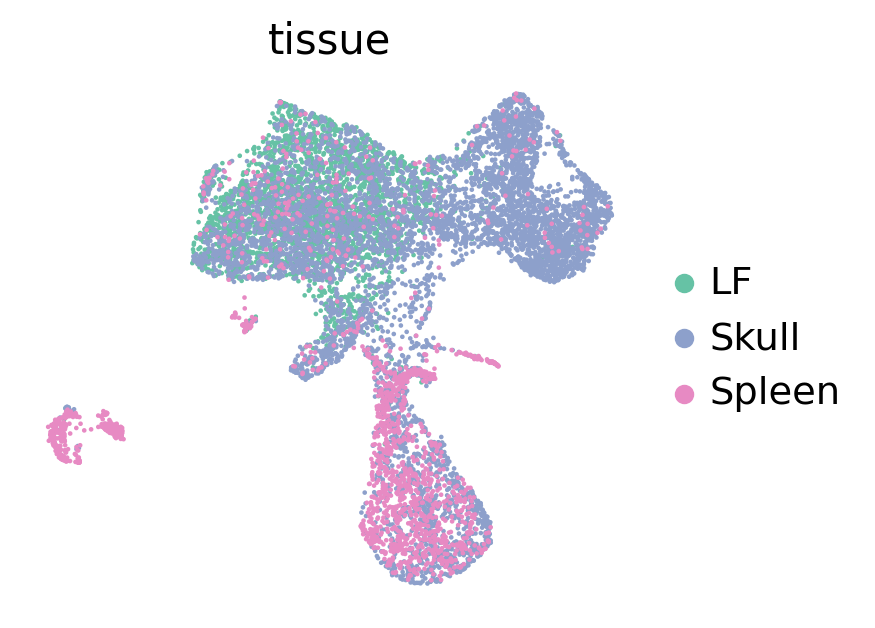

In [3]:
cs.pl.embedding(adata,color='tissue',frameon=False)

/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


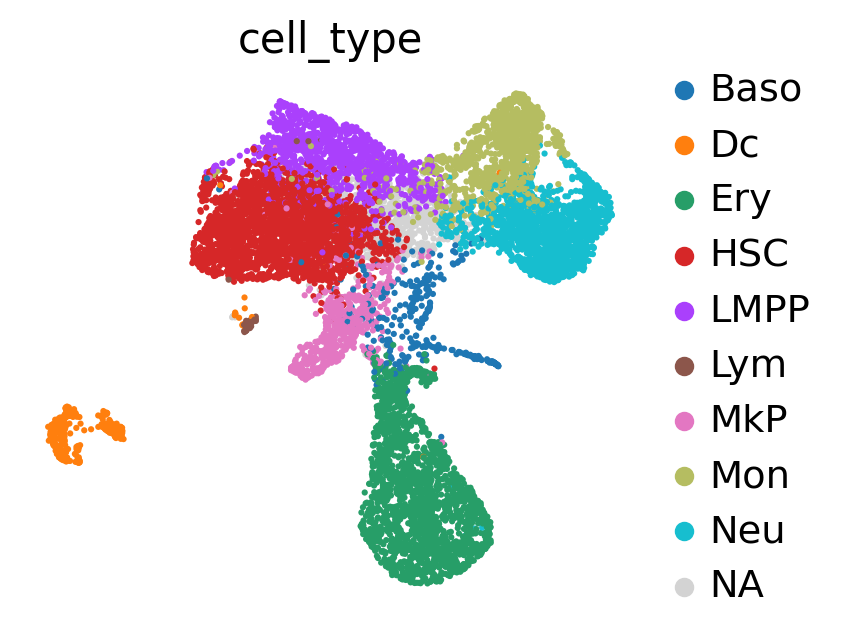

In [4]:
sc.pl.umap(adata,color='cell_type',s=20,frameon=False)

## Load clone data and integrate with RNA data

In [5]:
#The UMI count here is for the same allele across all cells, not within the same cell
df_sc_data=pd.read_csv(f'{root_path}/{target_sample}/df_sc_data_{read_cutoff}.csv') 

#this data has correct UMI count information
#df_sc_data=pd.read_csv(f'{root_path}/{target_sample}/df_sc_data_{read_cutoff}_from_SW_pipeline.csv') 
df_sc_data['RNA_id']=df_sc_data['sample'].apply(lambda x: '_'.join(x.split('-')))+'_'+df_sc_data['cell_bc']

In [6]:
# Identify reliable alleles and the corresponding RNA_id (UMI) should match that with transcriptome information
df_sc_data_HQ_with_RNA=df_sc_data[(~pd.isna(df_sc_data['joint_prob'])) 
                         & (df_sc_data['sample_count']<=max_rep_N) 
                         & (df_sc_data['RNA_id'].isin(adata.obs_names))] # & (df_sc_data['joint_allele_num']<5)]

In [9]:
df_sc_data_HQ_with_RNA.head(5)

allele  UMI_count    sample  mouse           cell_bc  CB_N  \
1699  CC_22_23insTA        240  LL837-LF  LL837  AAAGGATGTACAGCGA   240   
1700  CC_22_23insTA        240  LL837-LF  LL837  AAAGGATGTGTGCTTA   240   
1702  CC_22_23insTA        240  LL837-LF  LL837  AACAAAGGTAGGCAGT   240   
1703  CC_22_23insTA        240  LL837-LF  LL837  AACCATGTCACTACGA   240   
1704  CC_22_23insTA        240  LL837-LF  LL837  AACGGGAAGTAAACGT   240   

                                               clone_id  CARLIN_length  \
1699  CC_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACT...            278   
1700  CC_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACT...            278   
1702  CC_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACT...            278   
1703  CC_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACT...            278   
1704  CC_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACT...            278   

      clone_size  normalized_count  ...  invalid_alleles locus   library  \
1699         240          0.000008  ...            False    CC  LL837-LF   
1700         240          0.000008  ...            False    CC  LL837-LF   
1702         240          0.000008  ...            False    CC  LL837-LF   
1703         240          0.000008  ...            False    CC  LL837-LF   
1704         240          0.000008  ...            False    CC  LL837-LF   

      plate_ID                     RNA_id   lineage  \
1699  LL837-LF  LL837_LF_AAAGGATGTACAGCGA  LL837-LF   
1700  LL837-LF  LL837_LF_AAAGGATGTGTGCTTA  LL837-LF   
1702  LL837-LF  LL837_LF_AACAAAGGTAGGCAGT  LL837-LF   
1703  LL837-LF  LL837_LF_AACCATGTCACTACGA  LL837-LF   
1704  LL837-LF  LL837_LF_AACGGGAAGTAAACGT  LL837-LF   

                                     joint_clone_id_tmp  \
1699                              CC_22_23insTA@nan@nan   
1700                              CC_22_23insTA@nan@nan   
1702      CC_22_23insTA@nan@TC_131_132insGAA,199_227del   
1703  CC_22_23insTA@nan@TC_50_51insGGAAA,132_133deli...   
1704                              CC_22_23insTA@nan@nan   

                                         joint_clone_id joint_prob  \
1699                                      CC_22_23insTA    0.00002   
1700                                      CC_22_23insTA    0.00002   
1702          CC_22_23insTA@TC_131_132insGAA,199_227del    0.00000   
1703  CC_22_23insTA@TC_50_51insGGAAA,132_133delinsAA...    0.00000   
1704                                      CC_22_23insTA    0.00002   

      joint_allele_num  
1699               1.0  
1700               1.0  
1702               2.0  
1703               2.0  
1704               1.0  

[5 rows x 21 columns]

In [10]:
if not (df_sc_data['sample_count'].max()==3):
    raise ValueError('Should only use the Gr allele bank with 3 samples')

In [11]:
len(df_sc_data_HQ_with_RNA.RNA_id.unique())/adata.shape[0]

0.5340677652286614

In [9]:
# incorporate the lineage information into the adata object
cs.pp.get_X_clone(adata,df_sc_data_HQ_with_RNA['RNA_id'],df_sc_data_HQ_with_RNA['joint_clone_id'])

100%|████████████████████████████████████████████████████████████████| 5769/5769 [00:00<00:00, 635690.94it/s]


In [10]:
cs.pp.initialize_adata_object(adata)

AnnData object with n_obs × n_vars = 10802 × 21406
    obs: 'library', 'batch', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'cell_type', 'state_info', 'time_info', 'tissue', 'state_info_old'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable'
    uns: 'cell_type_colors', 'clonal_time_points', 'data_des', 'library_colors', 'neighbors', 'scrublet', 'state_info_colors', 'time_ordering', 'tissue_colors', 'umap', 'clone_id'
    obsm: 'X_clone', 'X_emb', 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [11]:
adata.write_h5ad(saved_adata_path)

## Load adata with both RNA and lineage

In [12]:
#adata_orig=cs.datasets.DARLIN_skull_hematopoiesis_Fig4()
adata_orig=cs.hf.read(saved_adata_path)

In [13]:
# Only keep cells from skull and remove Dc (as there are few Dc) 
adata_orig=adata_orig[adata_orig.obs['tissue'].isin(['Skull'])]
adata_orig=adata_orig[adata_orig.obs['state_info']!='Dc']
adata_orig.uns['data_des']=['Skull']

adata_orig.obs['cell_type']=adata_orig.obs['cell_type'].astype(str)
adata_orig.obs['cell_type']=pd.Categorical(adata_orig.obs['cell_type']).set_categories(['HSC', 'MkP','Ery', 'Baso', 'Neu', 'Mon', 'LMPP'], ordered=True)
adata_orig.uns['cell_type_colors']=['#d62728','#ff7f0e', '#1f77b4', '#279e68',  '#aa40fc', '#8c564b', '#e377c2'] #,'#d9d9d9']
adata_orig.obs['state_info']=adata_orig.obs['cell_type'].astype(str)

/tmp/ipykernel_3293037/3371179234.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_orig.uns['data_des']=['Skull']


## Manually annotate the time info
HSPCs are annotated as the initial population (t0), and the mature population are annotated as the later population (t1)

In [14]:
time_map={'LMPP':'t0', 'HSC':'t0', 'NA':'t1','Baso':'t1', 'MkP':'t1', 'Mon':'t1',  'Ery':'t1','Neu':'t1', 'Dc':'t1'}
adata_orig.obs['time_info']=adata_orig.obs['cell_type'].map(time_map)
cs.pp.initialize_adata_object(adata_orig)

AnnData object with n_obs × n_vars = 6094 × 21406
    obs: 'library', 'batch', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'cell_type', 'state_info', 'time_info', 'tissue', 'state_info_old'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable'
    uns: 'cell_type_colors', 'clonal_time_points', 'clone_id', 'data_des', 'library_colors', 'neighbors', 'scrublet', 'time_ordering', 'tissue_colors', 'umap'
    obsm: 'X_clone', 'X_emb', 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

## Transcriptomic analysis

/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


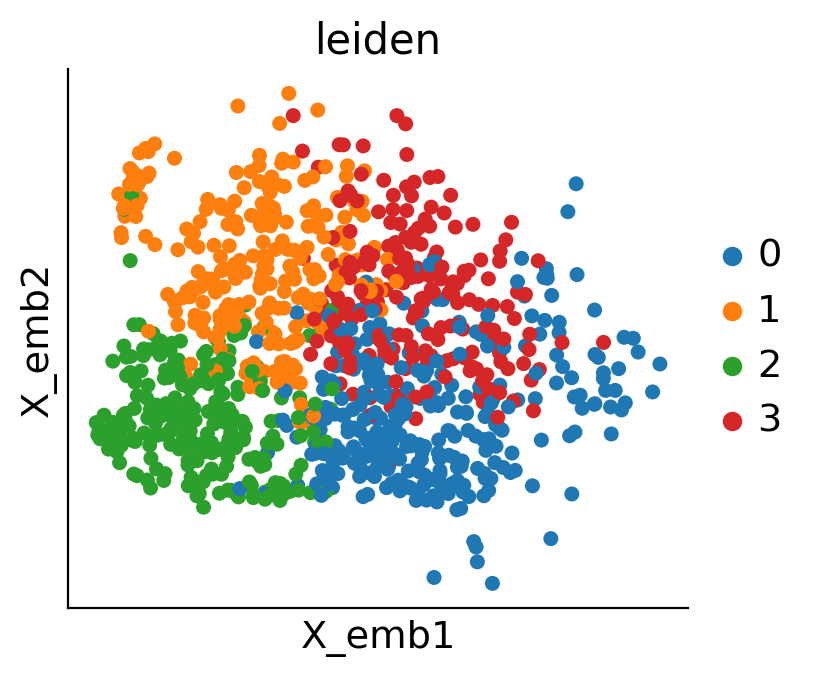

In [15]:
cs.pp.refine_state_info_by_leiden_clustering(adata_orig,selected_key='state_info',selected_values='HSC')

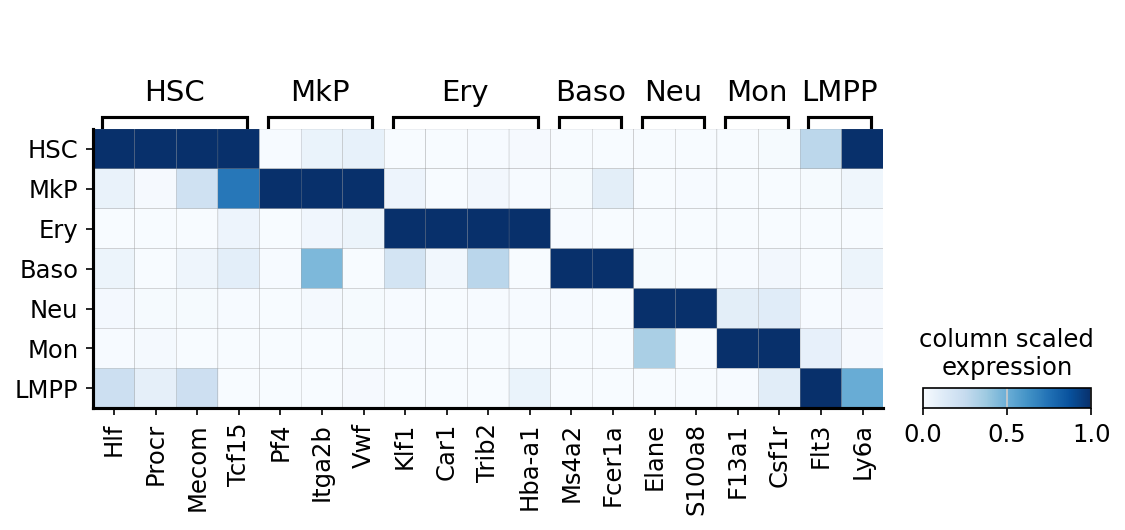

In [16]:
# markers per cell type:
celltype_genes={
'HSC' : ['Hlf', 'Procr','Mecom','Tcf15'],
'MkP' : ['Pf4', 'Itga2b', 'Vwf'],
'Ery' : ['Klf1', 'Car1','Trib2','Hba-a1' ],
'Baso' : ['Ms4a2', 'Fcer1a'],
'Neu' : [ 'Elane', 'S100a8'],
'Mon' :  ['F13a1', 'Csf1r'],
'LMPP' : ['Flt3','Ly6a']} #'Dntt','Cd79a','Cd19'

sc.settings.set_figure_params(dpi=75)#, facecolor='white')
sc.pl.matrixplot(adata_orig, celltype_genes, 
                 'cell_type', dendrogram=False, cmap='Blues', standard_scale='var', 
                 colorbar_title='column scaled\nexpression',save='matriplot_marker_genes')

In [17]:
make_gene_heatmap=False
if make_gene_heatmap:
    sc.tl.rank_genes_groups(adata_orig, 'cell_type', method='wilcoxon')
    sc.pl.rank_genes_groups(adata_orig, n_genes=10, sharey=False)

    adata_orig_sub=adata_orig[~pd.isna(adata_orig.obs['cell_type'])]
    sc.tl.filter_rank_genes_groups(adata_orig_sub)
    sc.pl.rank_genes_groups_heatmap(adata_orig_sub, n_genes=200, key='rank_genes_groups_filtered',
                                    swap_axes=True, use_raw=False, vmax=10, vmin=0, cmap='Reds', dendrogram=False,save='gene_heatmap')

/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


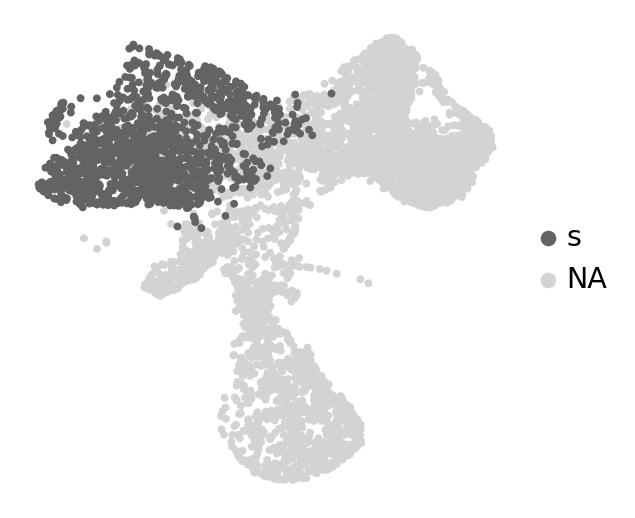

In [18]:
sc.settings.set_figure_params()
adata_orig.obs['selection']=np.nan
adata_orig.obs.loc[adata_orig.obs['time_info']=='t0','selection']='s'
sc.pl.embedding(adata_orig,color='selection',basis='X_umap',frameon=False,title='',palette={'s':'#636363'},
               save='_selection',size=50)

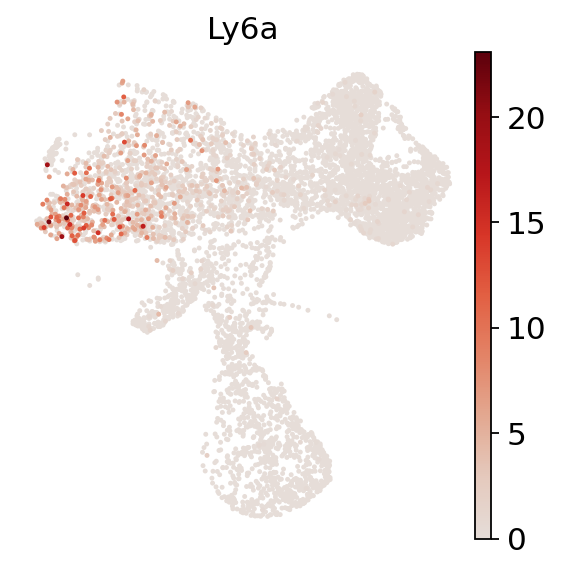

In [19]:
cs.pl.embedding(adata_orig,color='Ly6a',frameon=False)

/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


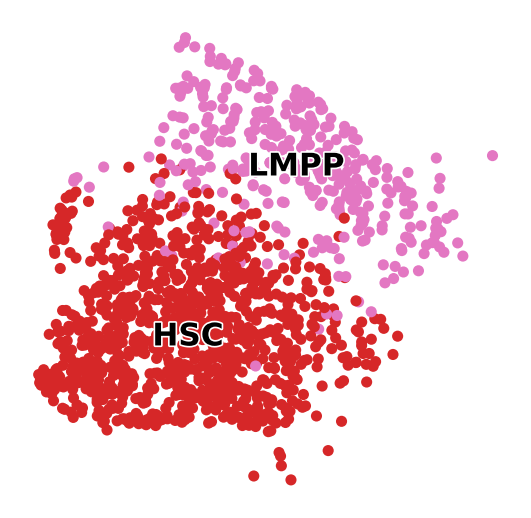

In [20]:
adata_t0=adata_orig[adata_orig.obs['time_info']=='t0']
sc.pl.embedding(adata_t0,color='cell_type',basis='X_umap',legend_loc='on data',
           legend_fontsize=14, legend_fontoutline=1.5,s=100,frameon=False,title='',
               save='_t0_cell_type')

/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


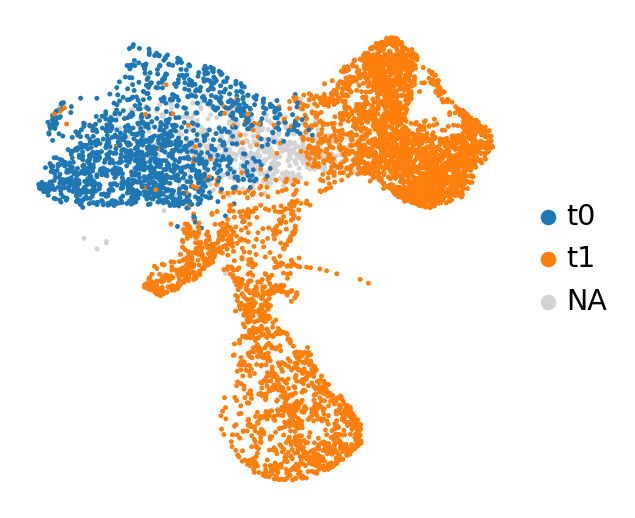

In [21]:
sc.pl.embedding(adata_orig,color='time_info',basis='X_umap',frameon=False,title='',
               save='_time_info')

/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


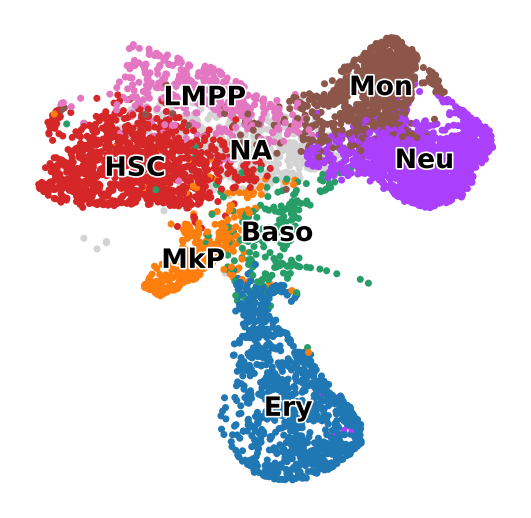

In [22]:
sc.pl.embedding(adata_orig,color='cell_type',basis='X_umap',frameon=False,title='',legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=1.5,s=40,
               save='_skull_celltypes')

## Basic clone statistics

In [23]:
df_clone=cs.tl.clone_statistics(adata_orig,joint_variable='state_info');

In [24]:
cs.tl.add_clone_id_for_each_cell(adata_orig)

In [25]:
np.sum((adata_orig.obsm['X_clone'].sum(0)>0).A.flatten())

1034

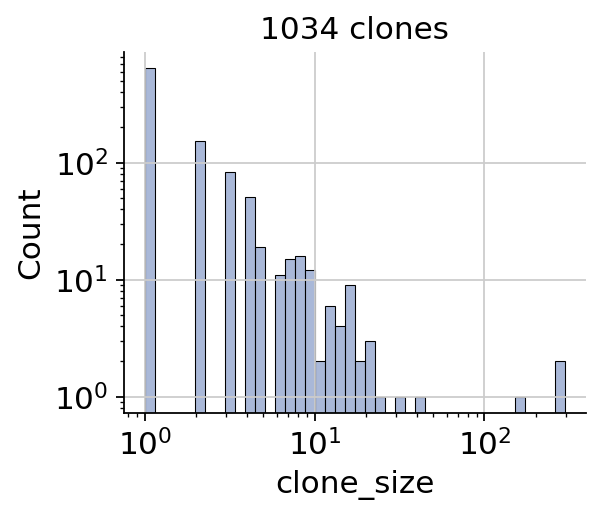

In [26]:
fig,ax=plt.subplots(figsize=(4,3.5))
sns.histplot(df_clone['clone_size'],log_scale=True,color='#8da0cb')
plt.yscale('log')
plt.title(f'{len(df_clone)} clones')
plt.tight_layout()
plt.savefig(f'{figure_path}/skull_clone_distribution.pdf')

In [27]:
df_cell_N=pd.DataFrame(adata_orig.obs['cell_type']).reset_index().groupby('cell_type').agg(count=('index','count')).reset_index()

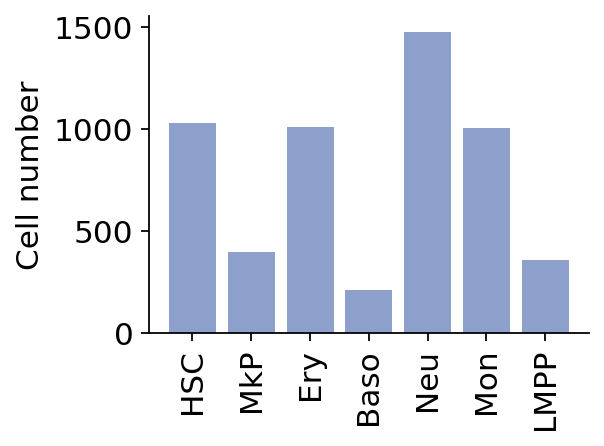

In [28]:
rcParams["axes.grid"] = False
fig,ax=plt.subplots(figsize=(4,3))
plt.bar(df_cell_N['cell_type'],df_cell_N['count'],color='#8da0cb')
#ax=sns.barplot(data=df_clone,x='state',y='clone_N',color=dict(zip(df_clone['state'],df_clone['color']))) #['black', 'red', 'green', 'blue', 'cyan'])
plt.xticks(rotation=90)
plt.ylabel('Cell number')
plt.tight_layout()
plt.savefig(f'{figure_path}/Skull_clone_number_per_cluster.pdf')

<Axes: xlabel='clone_size', ylabel='Count'>

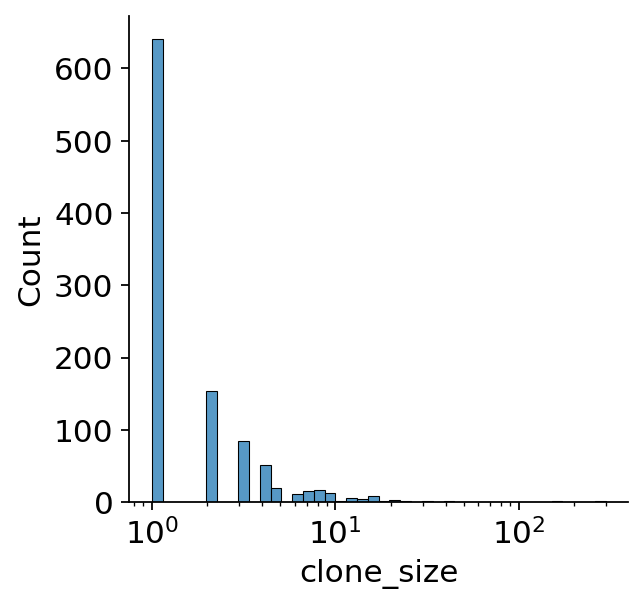

In [29]:
sns.histplot(df_clone['clone_size'],log_scale=True)
#plt.yscale('log')

## Clone output

In [30]:
all_clones_N=np.sum(adata_orig.obsm['X_clone'].A.sum(0)>0)

All clones (regardless of clone size)

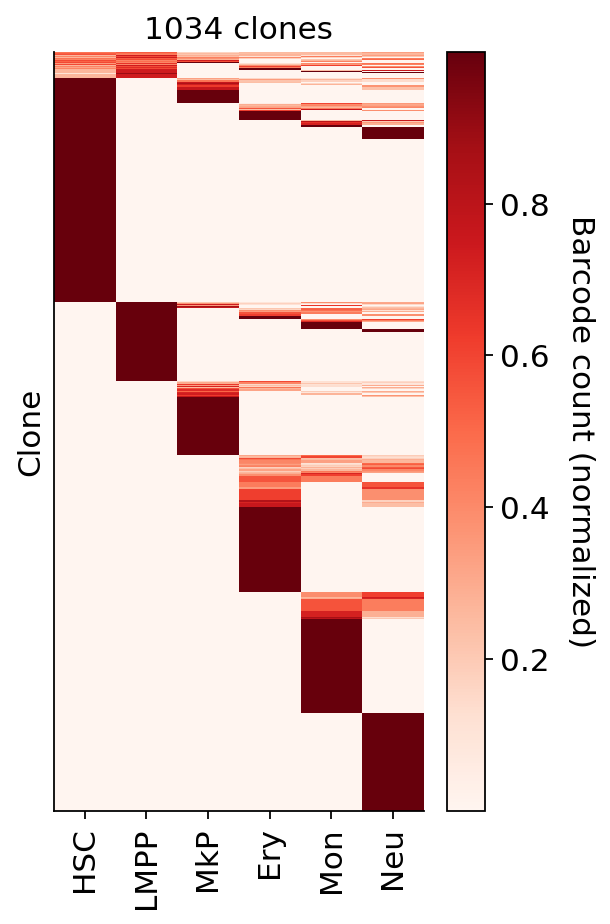

In [31]:
rcParams["axes.grid"] = False
selected_fates=['HSC',  'LMPP','MkP','Ery','Mon',  'Neu', ]
cs.pl.barcode_heatmap(adata_orig,selected_fates=selected_fates,normalize=True)
plt.ylabel('Clone')
plt.title(f'{all_clones_N} clones')
plt.tight_layout()
plt.savefig(f'{figure_path}/all_clone_heatmap.pdf')

only select clones with at least 1 cells

In [32]:
del adata_orig.uns['clone_id']
cs.tl.filter_clones(adata_orig, clone_size_threshold=2, filter_larger_clones=False)
clones_N_2cells=np.sum(adata_orig.obsm['X_clone'].A.sum(0)>0)

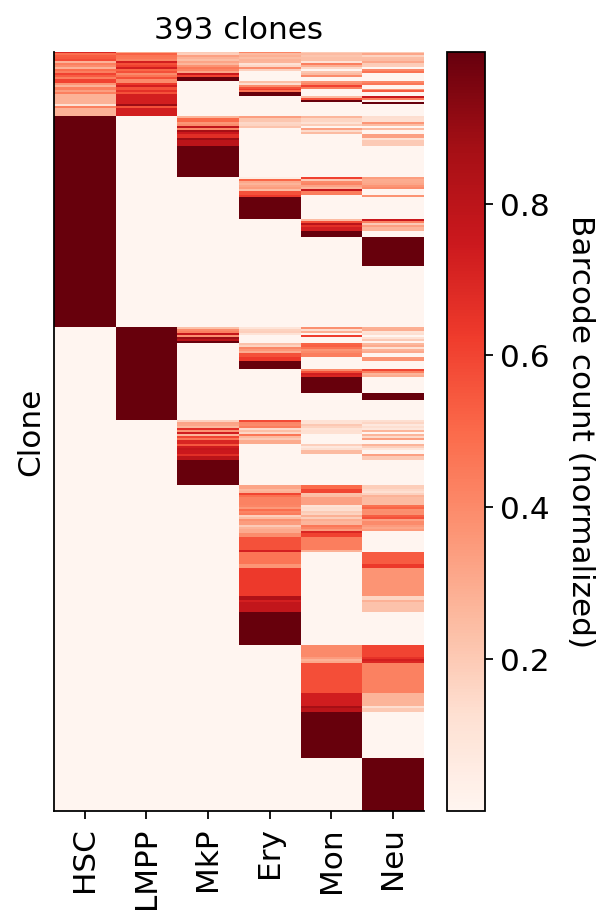

In [33]:
selected_fates=['HSC',  'LMPP','MkP','Ery','Mon',  'Neu', ]
cs.pl.barcode_heatmap(adata_orig,selected_fates=selected_fates,normalize=True)
plt.ylabel('Clone')
plt.title(f'{clones_N_2cells} clones')
plt.tight_layout()
plt.savefig(f'{figure_path}/all_clone_heatmap_>1.pdf')

## Select clones that label both HSC and LMPP

Select clones labeling only HSC

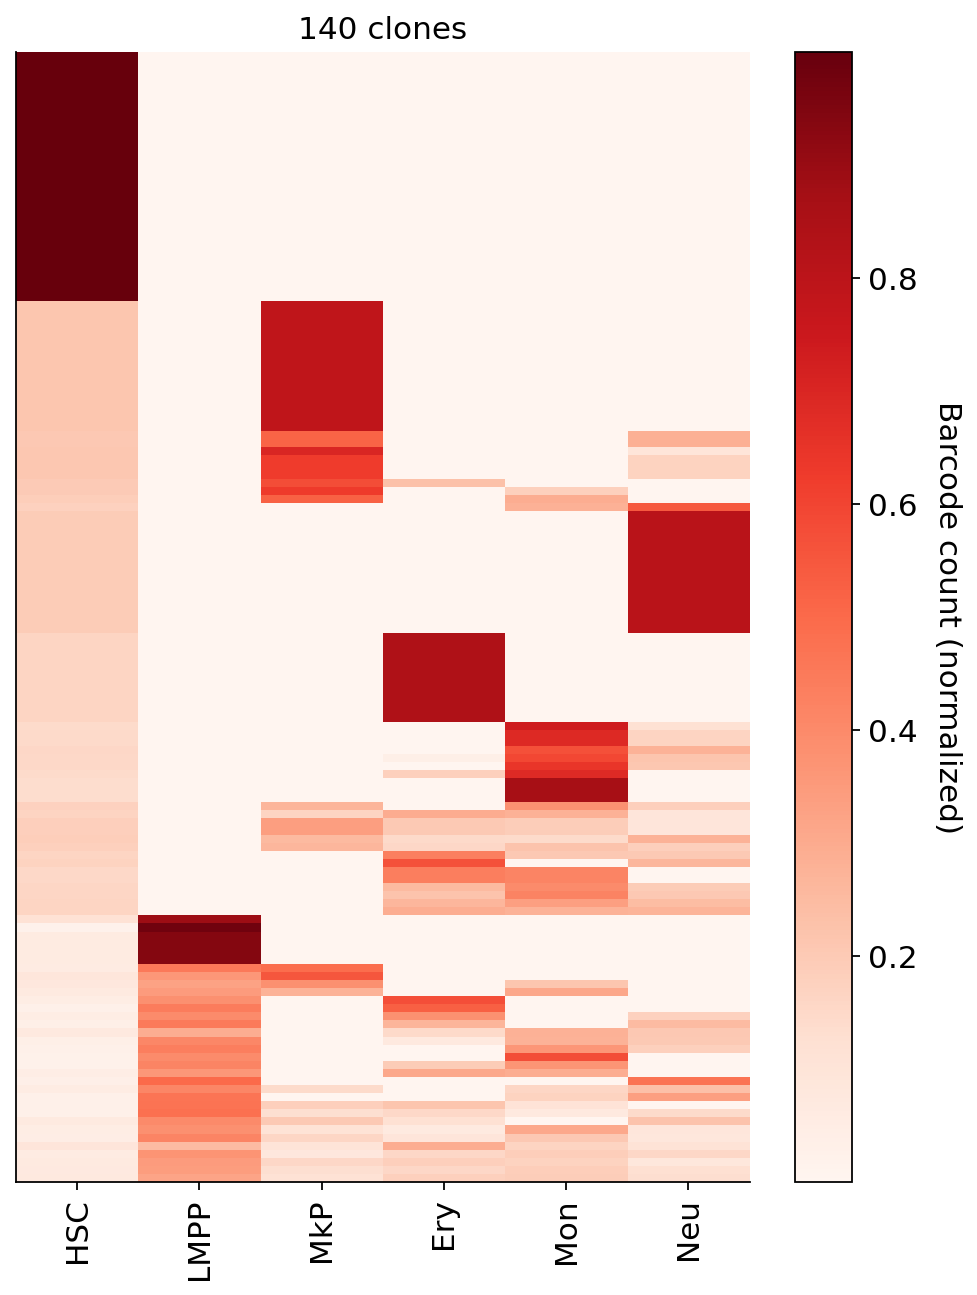

In [34]:
restricted_X_clone_HSC=cs.tl.conditional_heatmap(adata_orig.uns['barcode_heatmap']['coarse_X_clone'],
                                          adata_orig.uns['barcode_heatmap']['fate_names'],
                                          included_fates=['HSC'],normalize=True,mode='or')

Select clones labeling only LMPP

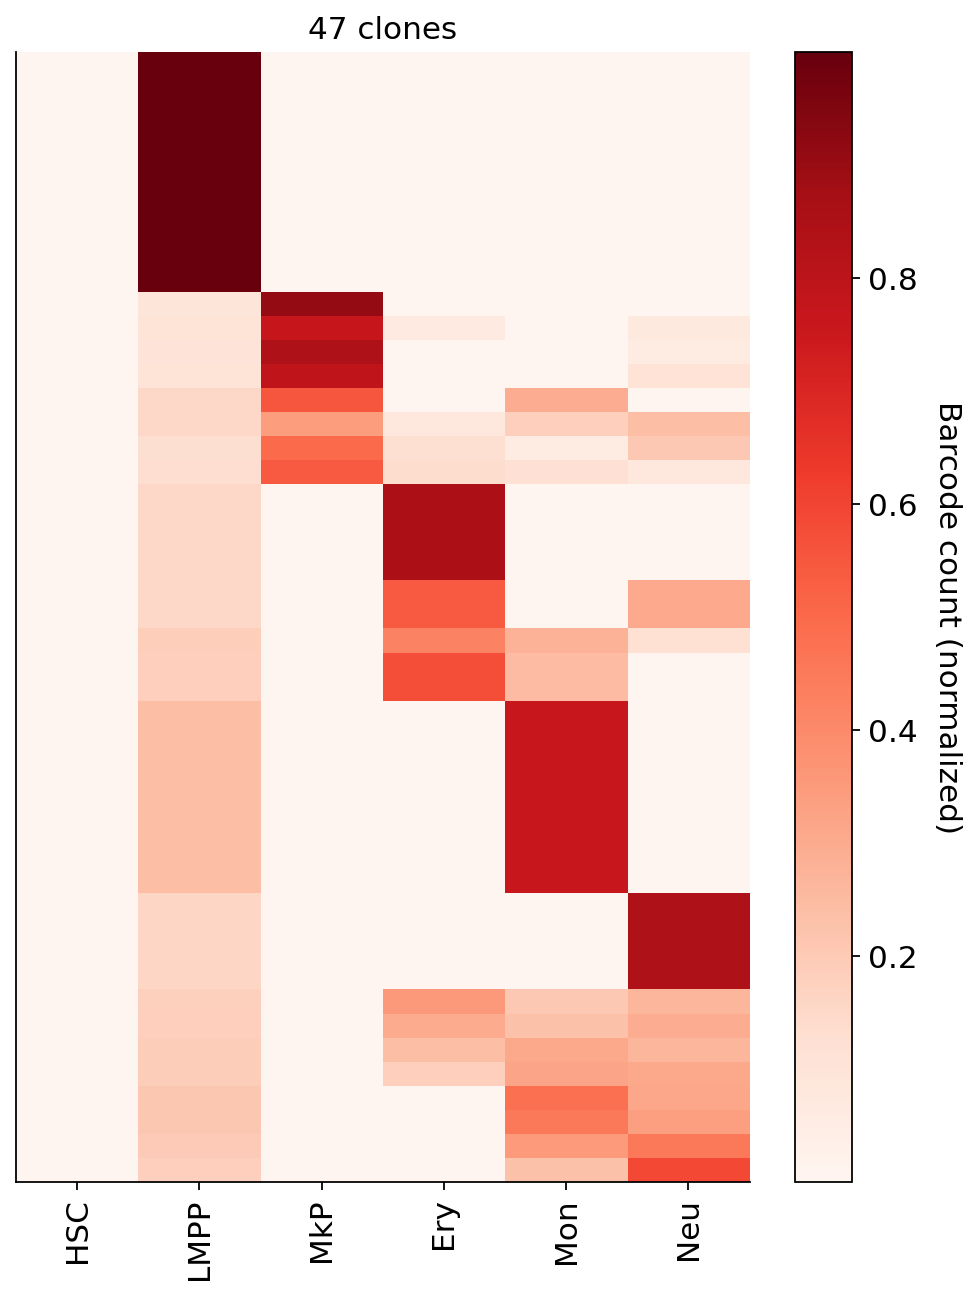

In [35]:
plt.rcParams["figure.figsize"]=(4,4)
restricted_X_clone_LMPP=cs.tl.conditional_heatmap(adata_orig.uns['barcode_heatmap']['coarse_X_clone'],
                                          adata_orig.uns['barcode_heatmap']['fate_names'],
                                          included_fates=['LMPP'],excluded_fates=['HSC'],normalize=True,mode='and')

Order these clones

In [36]:
restricted_X_clone_HSC_new=cs.pl.custom_hierachical_ordering(
        np.arange(restricted_X_clone_HSC.shape[0]), restricted_X_clone_HSC
    )

restricted_X_clone_LMPP_new=cs.pl.custom_hierachical_ordering(
        np.arange(restricted_X_clone_LMPP.shape[0]), restricted_X_clone_LMPP
    )

In [37]:
tot_clone_N_HSC_LMPP=np.hstack([restricted_X_clone_HSC_new,restricted_X_clone_LMPP_new]).T.shape[0]
print(tot_clone_N_HSC_LMPP,'clones')

187 clones


concatenate these clones

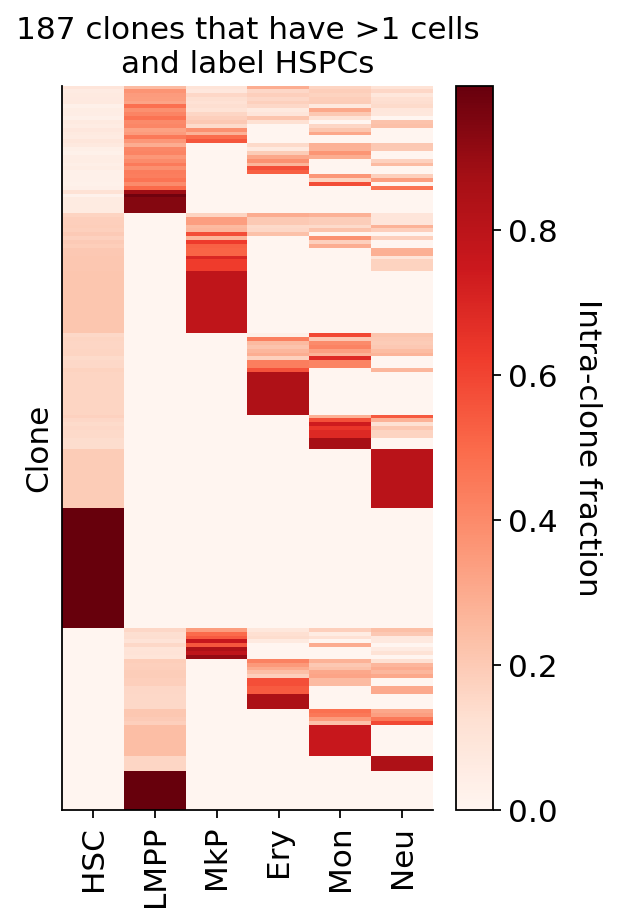

In [38]:
cs.pl.heatmap(np.hstack([restricted_X_clone_HSC_new,restricted_X_clone_LMPP_new]).T,order_map_x=False,order_map_y=False,
             x_ticks=adata_orig.uns['barcode_heatmap']['fate_names'],color_bar_label='Intra-clone fraction')
plt.ylabel('Clone')
plt.title(f'{tot_clone_N_HSC_LMPP} clones that have >1 cells\nand label HSPCs')
plt.tight_layout()
plt.savefig(f'{figure_path}/Skull_HSC_output.pdf')

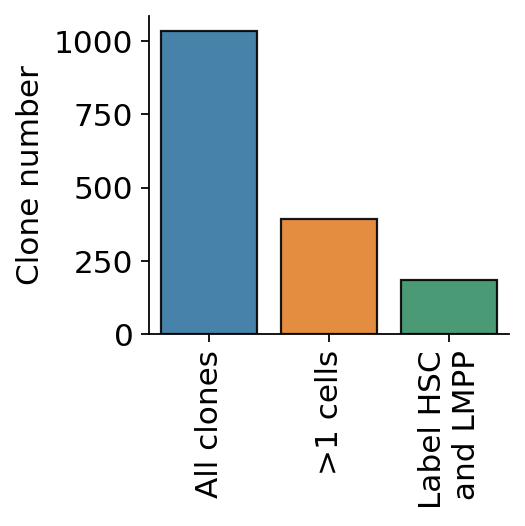

In [39]:
fig,ax=plt.subplots(figsize=(3.5,3.5))
kwargs = {'alpha':0.9, 'linewidth':1, 'edgecolor':'k'}
ax=sns.barplot(x=[1,2,3],y=[all_clones_N,clones_N_2cells,tot_clone_N_HSC_LMPP],**kwargs)
ax.set_xticks([0,1,2], ['All clones','>1 cells','Label HSC\n and LMPP'], #['All clones', 'Clones with \n >1 cells', 'Clones with \n HSPCs \n and >1 cells'],
       rotation=90)  # Set text labels and properties.
ax.set_ylabel('Clone number')
plt.tight_layout()
plt.savefig(f'{figure_path}/clone_number_breakdown.pdf')

In [40]:
X0=np.hstack([restricted_X_clone_HSC_new,restricted_X_clone_LMPP_new]).T[:,2:]
X1=X0[X0.sum(1)>0] # only select clones with both state and fate outcomes
frac=np.sum((X1/(X1.sum(1)[:,np.newaxis]+10**(-10)))>0.99,axis=1).mean()
print(f'{100*frac:.2f}% of {len(X1)} clones ({X1[0]}) labling early progenitor have a single fate outcome')

48.57% of 140 clones ([0.09811269 0.28963016 0.16509398 0.10756418]) labling early progenitor have a single fate outcome


## Clonal coupling between cell types and their p-values

In [41]:
adata_output,X_coupling_random=cs.tl.pvalue_for_fate_coupling(adata_orig,selected_fates=selected_fates,max_N_simutation=10000,normalize=True)

/mnt/data/shared/packages/cospar/cospar/tool/_map.py:371: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["time_info"] = pd.Categorical(adata.obs["time_info"].astype(str))
/mnt/data/shared/packages/cospar/cospar/help_functions/_help_functions_CoSpar.py:1155: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["available_map"] = available_map
100%|██████████████████████████████████████████████████████████████████| 10000/10000 [05:52<00:00, 28.41it/s]


<Axes: ylabel='Count'>

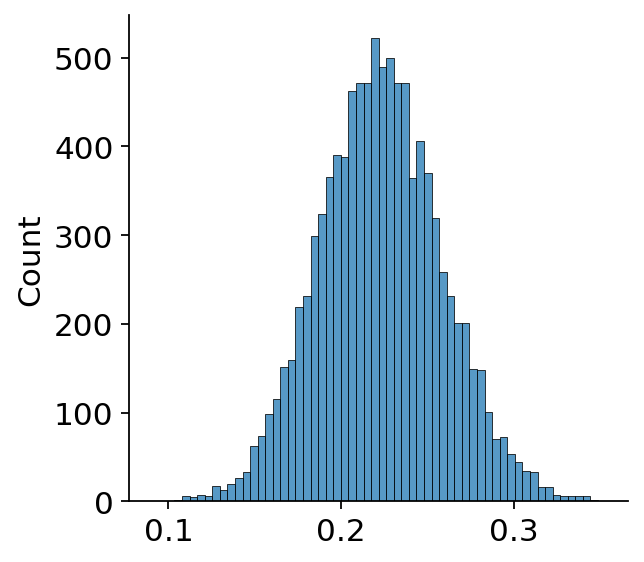

In [42]:
sns.histplot(X_coupling_random[:,0,2])

In [43]:
X_coupling=adata_output.uns['fate_coupling_X_clone']['X_coupling']
fate_names=adata_output.uns['fate_coupling_X_clone']['fate_names']
pvalue=adata_output.uns['fate_coupling_X_clone']['pvalue']
pvalue_greater=adata_output.uns['fate_coupling_X_clone']['pvalue_greater']
pvalue_less=adata_output.uns['fate_coupling_X_clone']['pvalue_less']

The coupling matrix has been computed, and can be visualized directly

<Axes: >

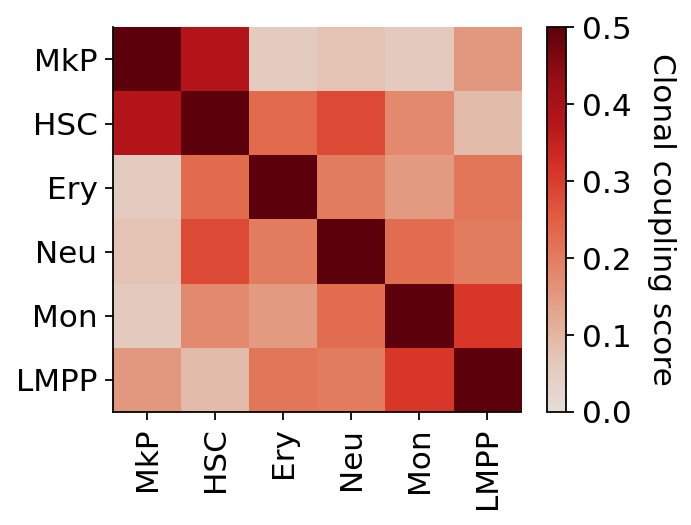

In [44]:
cs.pl.fate_coupling(adata_output, source="X_clone",vmax=0.5,vmin=0,title='',figure_index='clonal_coupling')  # actually plot the coupling

In [45]:
new_fate_names=['MkP','HSC','Ery','Neu','Mon','LMPP']
sp_id=[]
for x in new_fate_names:
    sp_id.append(np.nonzero(fate_names==x)[0][0])
    
ordered_pvalue_greater=pvalue_greater[sp_id][:,sp_id]
ordered_pvalue_greater=np.nan_to_num(ordered_pvalue_greater,nan=1)

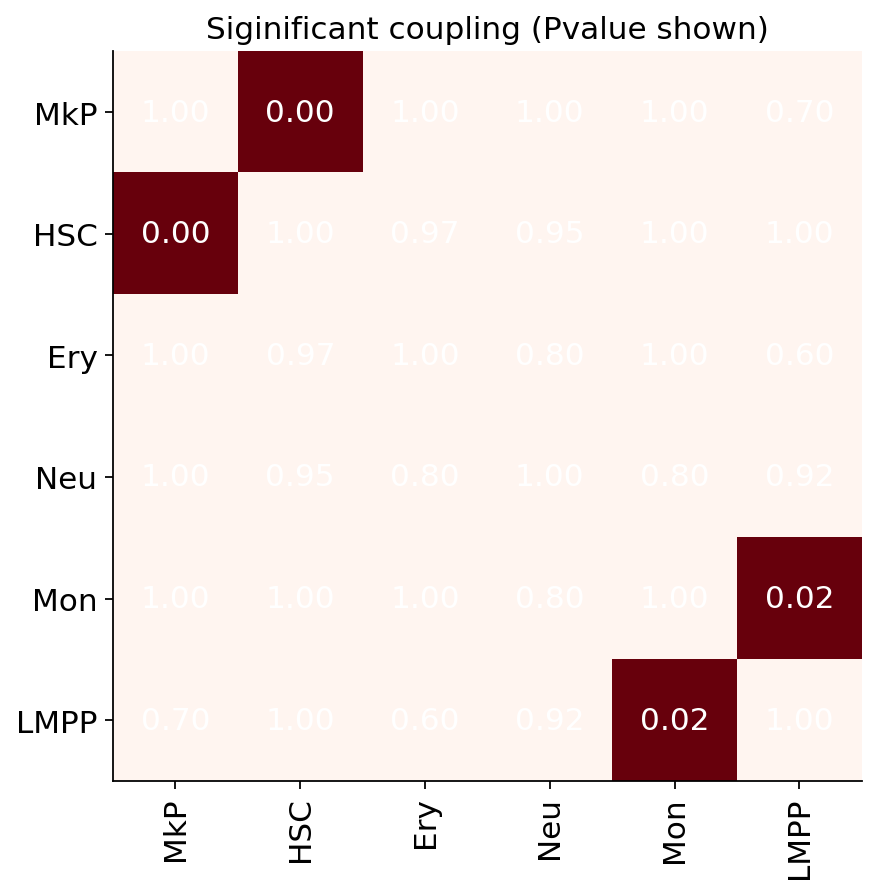

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for the heatmap
data = np.random.rand(5, 5)

# Create a heatmap
ax=cs.pl.heatmap((ordered_pvalue_greater<0.05).astype(float),
              order_map_x=False,order_map_y=False,fig_width=6,color_bar=False,
              x_ticks=new_fate_names,y_ticks=new_fate_names)

# Add text annotations to the heatmap cells
for i in range(ordered_pvalue_greater.shape[0]):
    for j in range(ordered_pvalue_greater.shape[1]):
        plt.text(j, i, f'{ordered_pvalue_greater[i, j]:.2f}', ha='center', va='center', color='white')
        
ax.set_title('Siginificant coupling (Pvalue shown)')
plt.show()

In [47]:
cs.tl.fate_hierarchy(
    adata_orig, selected_fates=selected_fates, source="X_clone"
)  # compute the fate hierarchy
cs.pl.fate_hierarchy(adata_orig, source="X_clone")  # actually plot the hierarchy


            /-Mon
         /-|
      /-|   \-LMPP
     |  |
   /-|   \-Neu
  |  |
--|   \-Ery
  |
  |   /-MkP
   \-|
      \-HSC


## Progenitors with the same observed clonal fate bias

In [48]:
df_clone=cs.tl.clone_statistics(adata_orig,joint_variable='state_info');

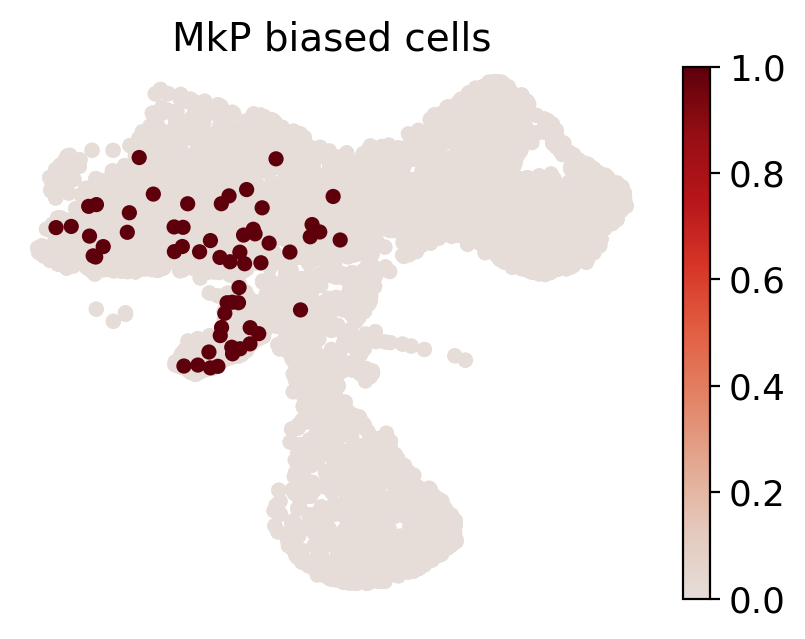

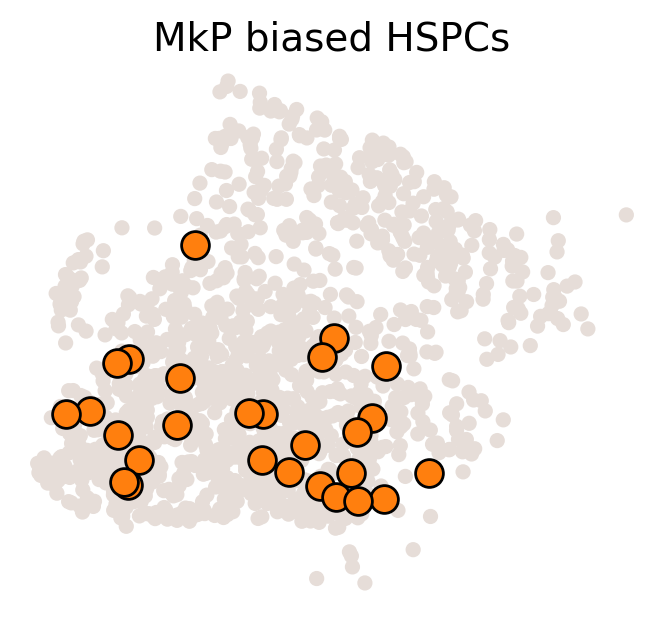

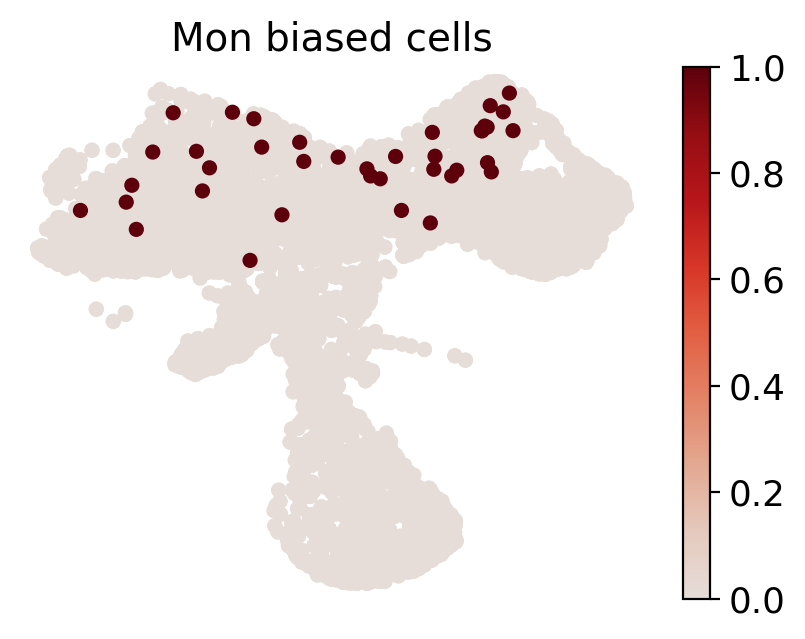

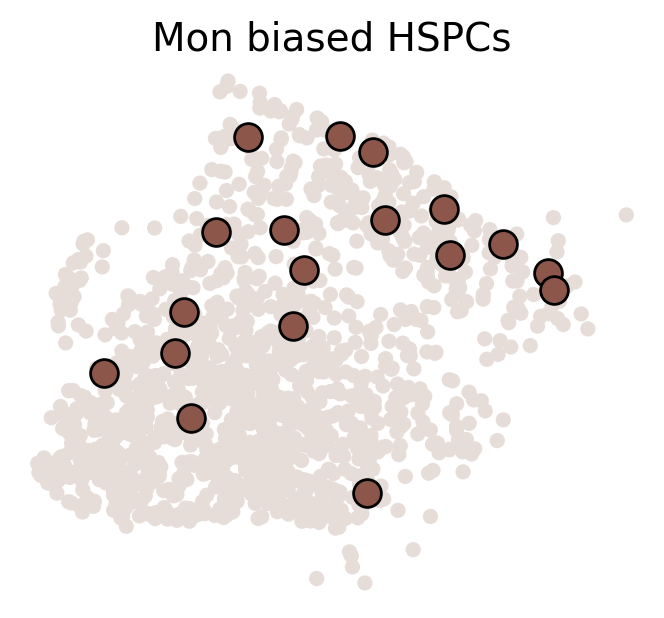

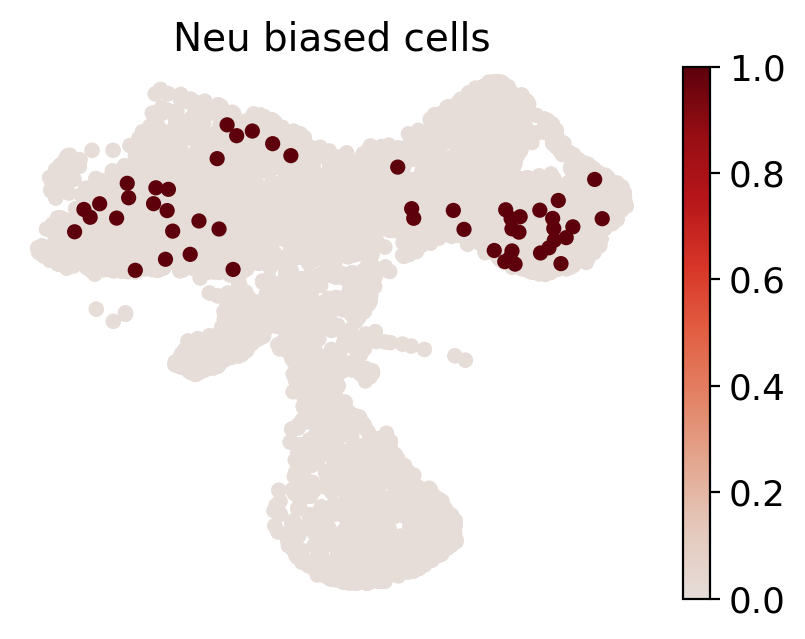

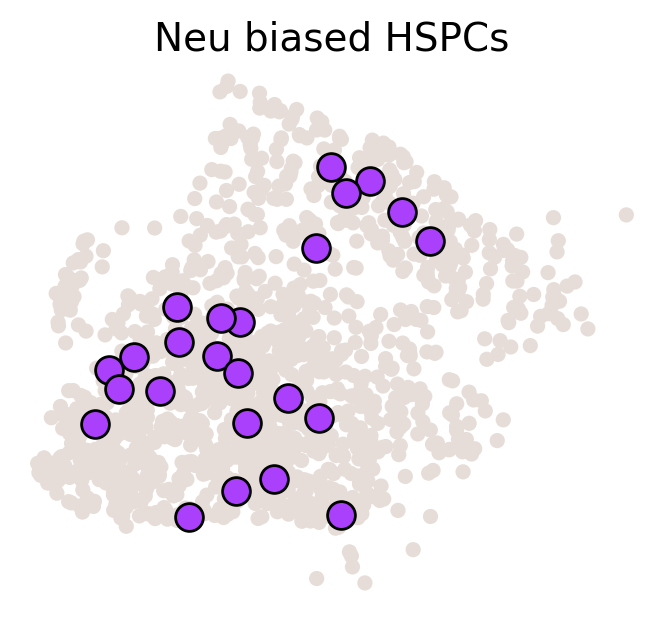

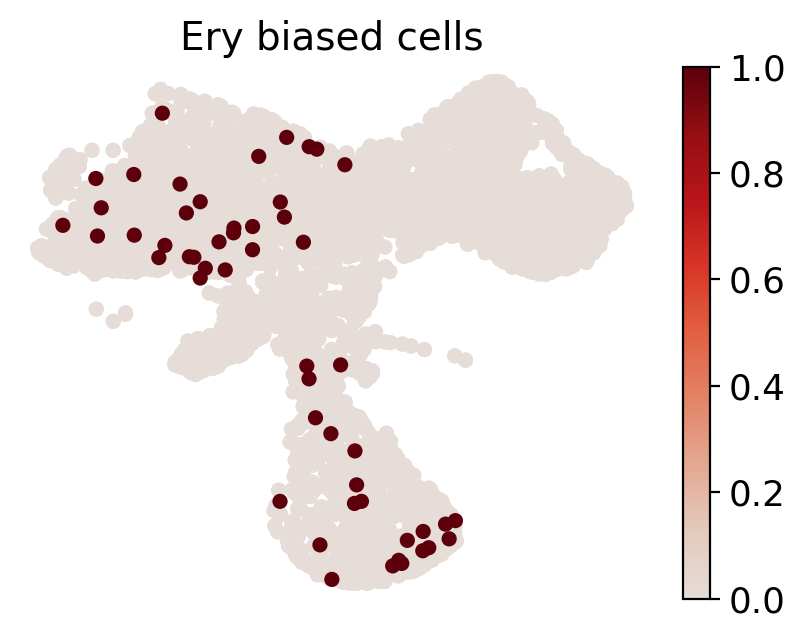

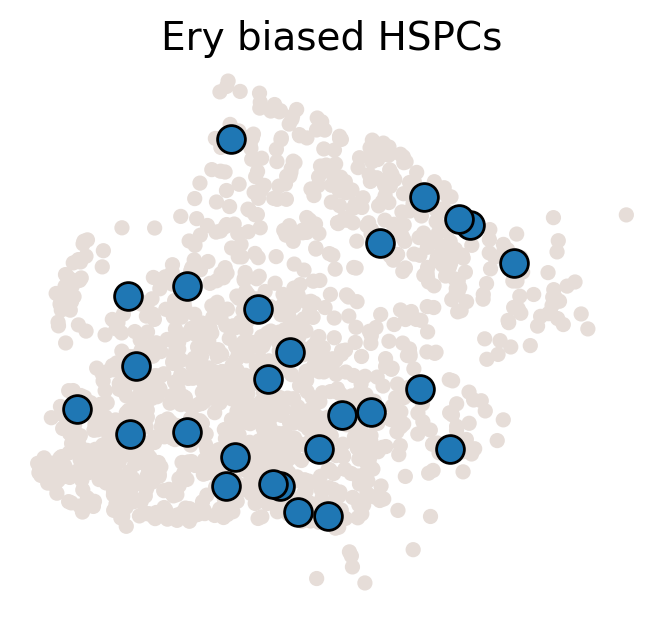

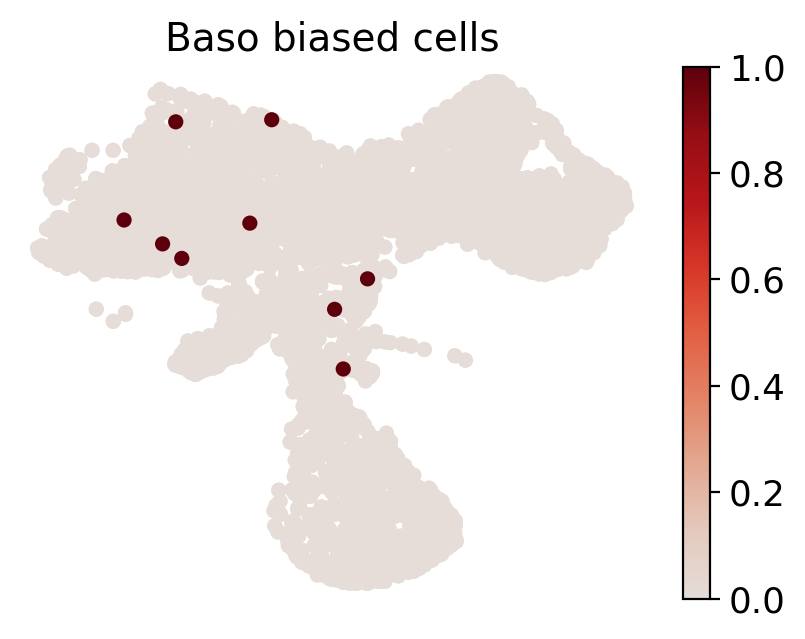

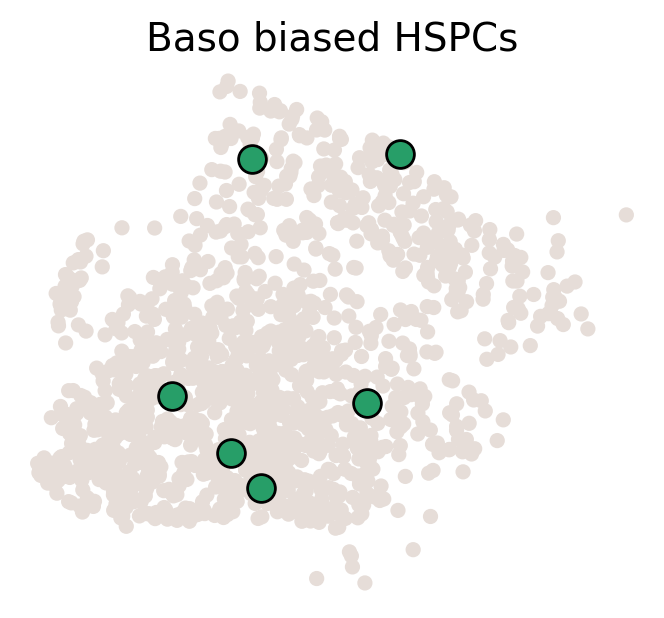

In [49]:
ref_fates=['MkP','Mon','Neu','Ery','Baso']
cs.settings.set_figure_params(pointsize=20)
df_clone['state_info']=df_clone['state_info'].str.split(',').apply(lambda x: sorted(x)).apply(lambda x:','.join(x))
celltype_colors=dict(zip(adata_orig.obs['cell_type'].cat.categories,adata_orig.uns['cell_type_colors']))
for fate_tmp in ref_fates:
    all_fates_tmp=ref_fates.copy()
    all_fates_tmp.remove(fate_tmp)
    df_clone_sub=df_clone[df_clone['state_info'].apply(lambda x: (fate_tmp in x) & (('HSC' in x)  or ('LMPP' in x)) & (np.sum([__ in x for __ in all_fates_tmp])==0) )]


    MkP_bias=(adata_orig.obsm['X_clone'][:,df_clone_sub['clone_id'].to_numpy()].sum(1).A.flatten()>0).astype(int)
    cell_id_t1=np.ones(len(MkP_bias)).astype(bool)
    sp_idx=np.arange(np.sum(cell_id_t1))

    cs.pl.fate_map_embedding(adata_orig,MkP_bias,cell_id_t1=cell_id_t1,sp_idx=sp_idx,
                            figure_title=f'{fate_tmp} biased cells')
    
    
    color_tmp=celltype_colors[fate_tmp]
    adata_tmp=adata_orig.copy()
    adata_tmp.uns['data_des']=['all_bias_clones']
    adata_tmp.obsm['X_clone']=ssp.csr_matrix(np.array([(MkP_bias>0).astype(int)])).T
    ax=cs.pl.clones_on_manifold(adata_tmp,selected_clone_list=[0],
                            color_list=[color_tmp,color_tmp,color_tmp],clone_markersize=20,
                            selected_times='t0')
    ax.set_title(f'{fate_tmp} biased HSPCs')
    plt.savefig(f'{cs.settings.figure_path}/all_mkp_bias_clones_different_clones_{fate_tmp}.pdf')
    

## Identify MkP-fate biased clones

100%|█████████████████████████████████████████████████████████████████████| 393/393 [00:01<00:00, 359.51it/s]
/mnt/data/shared/packages/cospar/cospar/tool/_clone.py:160: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["clonal_fate_bias"] = df_final[df_final["clone_size"] > 0]


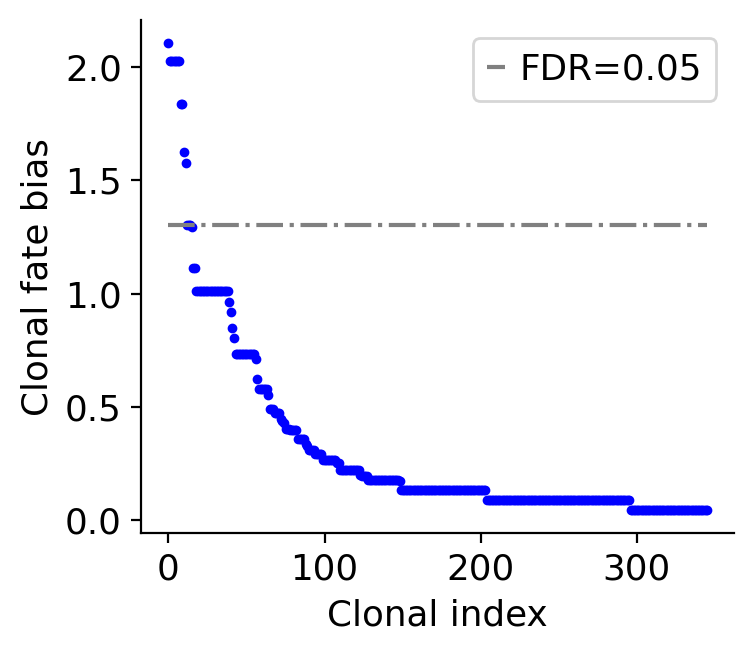

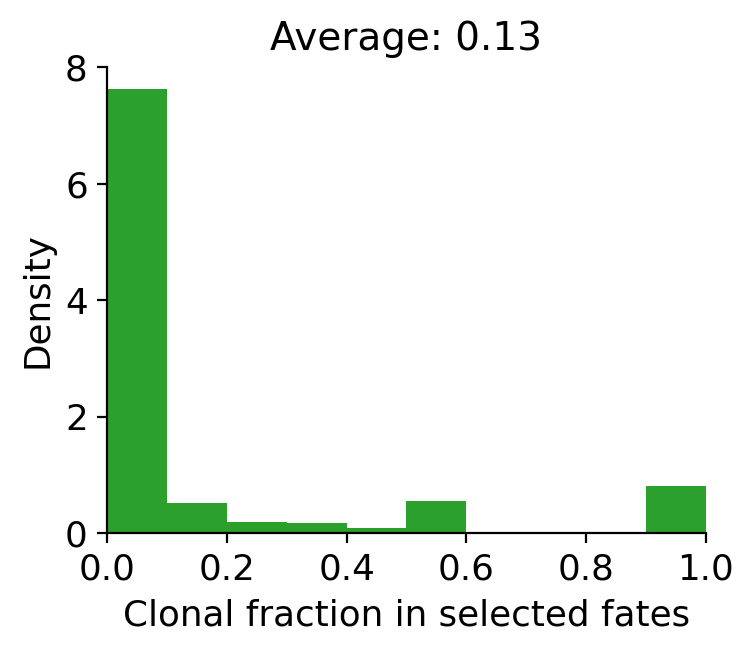

In [50]:
adata_orig_t2=adata_orig[adata_orig.obs['time_info']=='t1']
cs.tl.clonal_fate_bias(
    adata_orig_t2, selected_fate="MkP", alternative="two-sided"
)  
cs.pl.clonal_fate_bias(adata_orig_t2) 
df_pvalue_MkP=adata_orig_t2.uns['clonal_fate_bias']

<Axes: xlabel='P_value', ylabel='Count'>

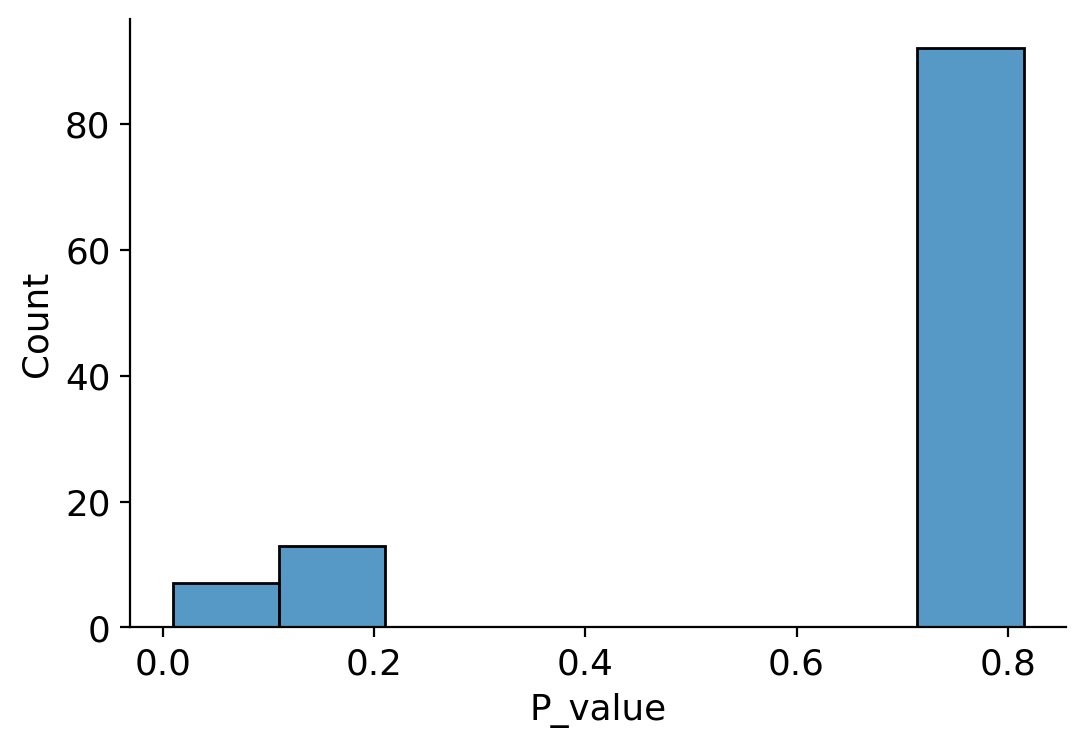

In [51]:
sns.histplot(df_pvalue_MkP[df_pvalue_MkP['clone_size']==2]['P_value'])

In [52]:
df_clone_sub=df_clone[df_clone['state_info'].apply(lambda x: x=='HSC,MkP')]
df_clone_sub=df_clone_sub.merge(df_pvalue_MkP.filter(['clone_id','clonal_fraction_in_target_fate','P_value','clone_size']),on=['clone_id'])
df_clone_sub

clone_id  clone_size_x state_info  state_info_N  \
0         41             2    HSC,MkP             2   
1        104             2    HSC,MkP             2   
2        107             2    HSC,MkP             2   
3        135             2    HSC,MkP             2   
4        163             6    HSC,MkP             2   
5        181             4    HSC,MkP             2   
6        196             2    HSC,MkP             2   
7        198             3    HSC,MkP             2   
8        305             3    HSC,MkP             2   
9        307             2    HSC,MkP             2   
10       318             3    HSC,MkP             2   
11       371             2    HSC,MkP             2   

    clonal_fraction_in_target_fate   P_value  clone_size_y  
0                              1.0  0.097317           1.0  
1                              1.0  0.097317           1.0  
2                              1.0  0.097317           1.0  
3                              1.0  0.097317           1.0  
4                              1.0  0.097317           1.0  
5                              1.0  0.009449           2.0  
6                              1.0  0.097317           1.0  
7                              1.0  0.097317           1.0  
8                              1.0  0.097317           1.0  
9                              1.0  0.097317           1.0  
10                             1.0  0.009449           2.0  
11                             1.0  0.097317           1.0

<Axes: title={'center': 'ID: 318'}>

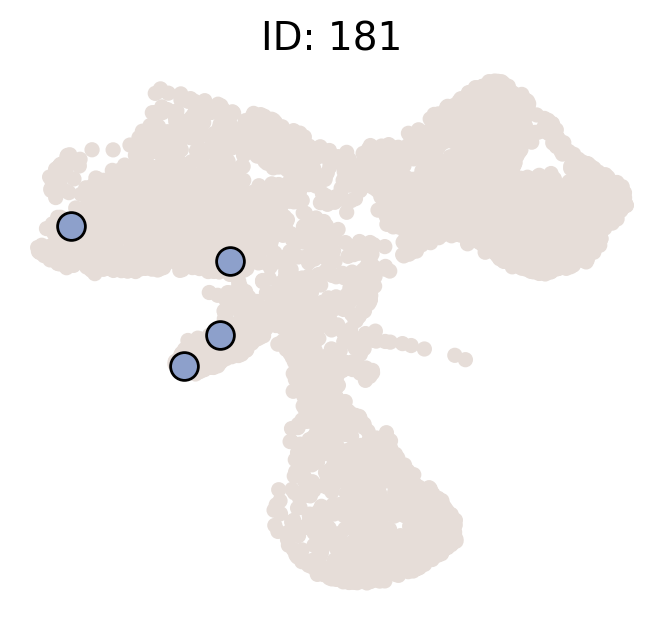

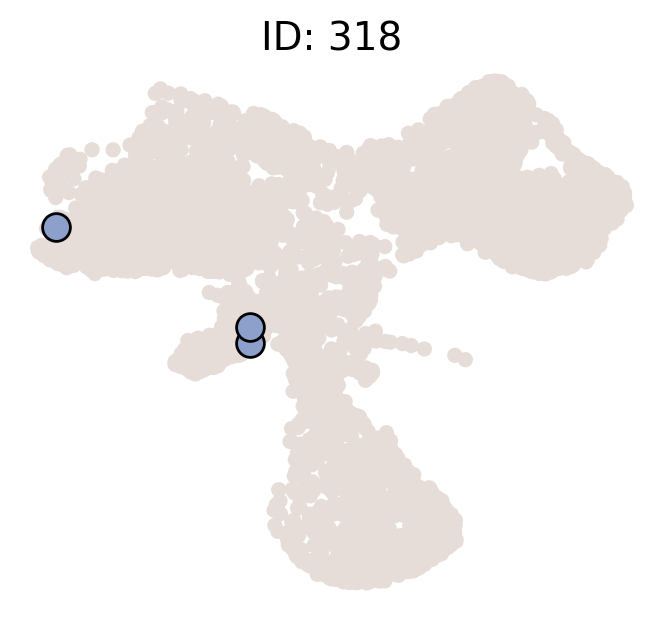

In [53]:
cs.pl.clones_on_manifold(adata_orig,selected_clone_list=df_clone_sub.query('P_value<0.05').clone_id.to_list(),
                        color_list=['#8da0cb','#8da0cb','#8da0cb'],clone_markersize=20)


## CoSpar predicted fate bias

In [54]:
adata = cs.tmap.infer_Tmap_from_multitime_clones(
    adata_orig,
    clonal_time_points=["t0"],
    later_time_point="t1",
    smooth_array=[10,10,5],
    sparsity_threshold=0.1,
    intraclone_threshold=0.2,
    max_iter_N=10,
    epsilon_converge=0.01,
)

/mnt/data/shared/packages/cospar/cospar/tmap/map_reconstruction.py:237: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["data_des"] = [data_des_orig, data_des]


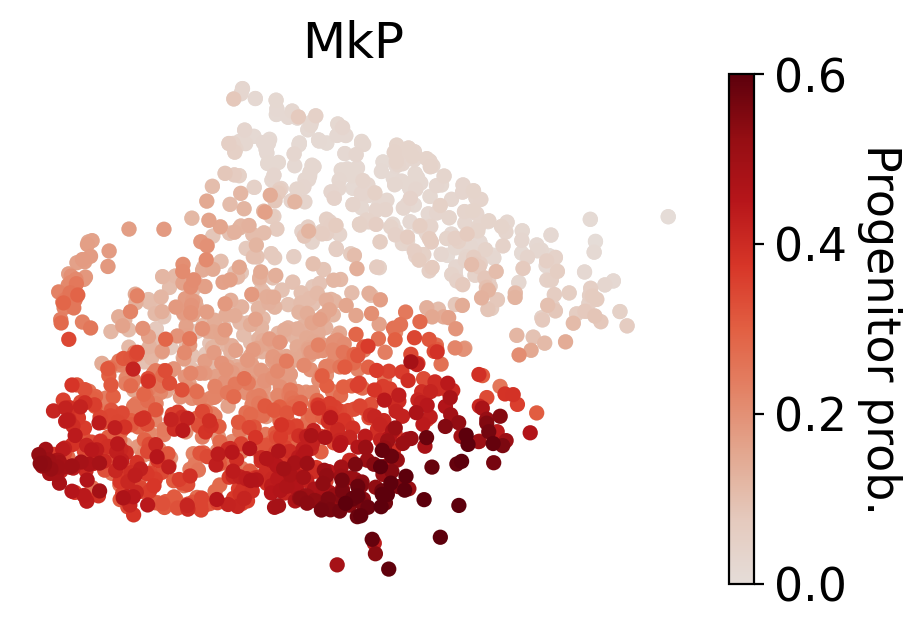

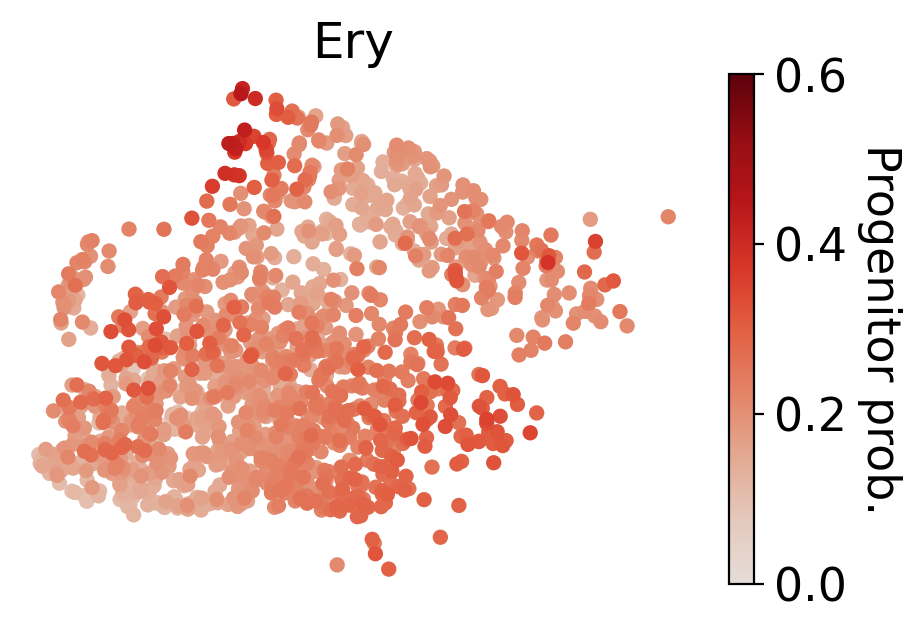

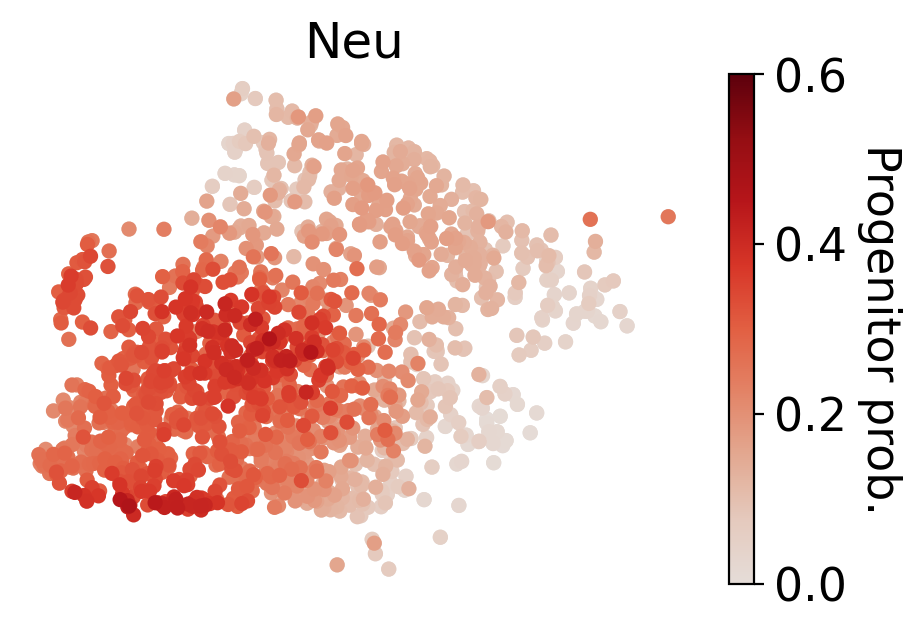

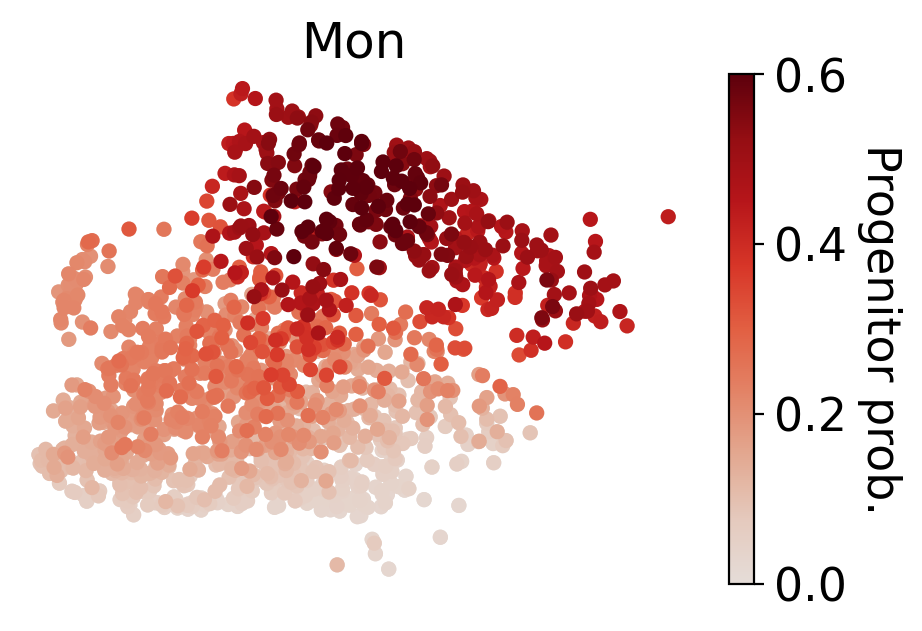

In [55]:
cs.settings.set_figure_params(pointsize=20,fontsize=18)
for selected_fates in [['MkP'],['Ery'],['Neu'],['Mon']]:
    cs.tl.fate_map(
        adata,
        selected_fates=selected_fates,
        source="transition_map",
        map_backward=True,
    )
    cs.pl.fate_map(
        adata,
        selected_fates=selected_fates,
        selected_times='t0',
        source="transition_map",
        plot_target_state=False,
        background=False,
        show_histogram=False,
        auto_color_scale=False,
        vmax=0.6,
        
    )

## Differential gene analysis

In [56]:
adata.obs['Fate_bias']=np.nan
sel_idx_1=((adata.obs['fate_map_transition_map_MkP']>0.25) & (adata.obsm['X_emb'][:,0]<4))
adata.obs.loc[sel_idx_1,'Fate_bias']='Early MkP bias'
sel_idx_2=((adata.obs['fate_map_transition_map_MkP']>0.25) & (adata.obsm['X_emb'][:,0]>=4))
adata.obs.loc[sel_idx_2,'Fate_bias']='Late MkP bias'
#sel_idx_3=((adata.obs['fate_map_transition_map_MkP']<=0.25)) & (adata.obs['time_info']=='t0')
sel_idx_3=((adata.obs['fate_map_transition_map_MkP']<=0.25)) & (adata.obs['state_info']=='HSC')
adata.obs.loc[sel_idx_3,'Fate_bias']='No MkP bias'
sel_idx_4=(adata.obs['state_info']=='LMPP')
adata.obs.loc[sel_idx_4,'Fate_bias']='LMPP'
adata_sub=adata[adata.obs['time_info']=='t0']

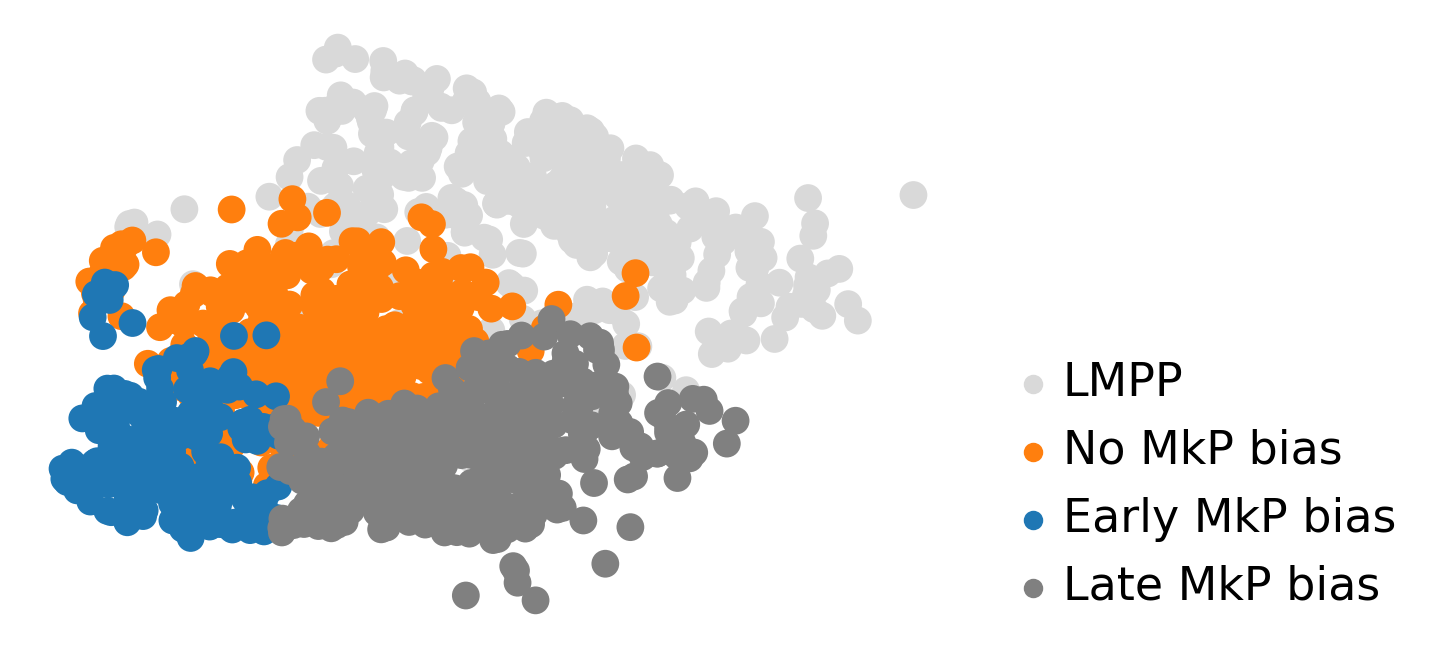

In [57]:
cs.pl.plot_adata_with_prefered_order(adata,'Fate_bias',plot_order=['LMPP','No MkP bias','Early MkP bias','Late MkP bias' ],
                              palette={'LMPP':'#d9d9d9','No MkP bias':'#ff7f0e','Early MkP bias':'#1f77b4','Late MkP bias':'grey'},
                              linewidth = 0,s=100)
#plt.tight_layout()
plt.savefig(f'{figure_path}/X_emb_fate_bias_MkP.pdf')

/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


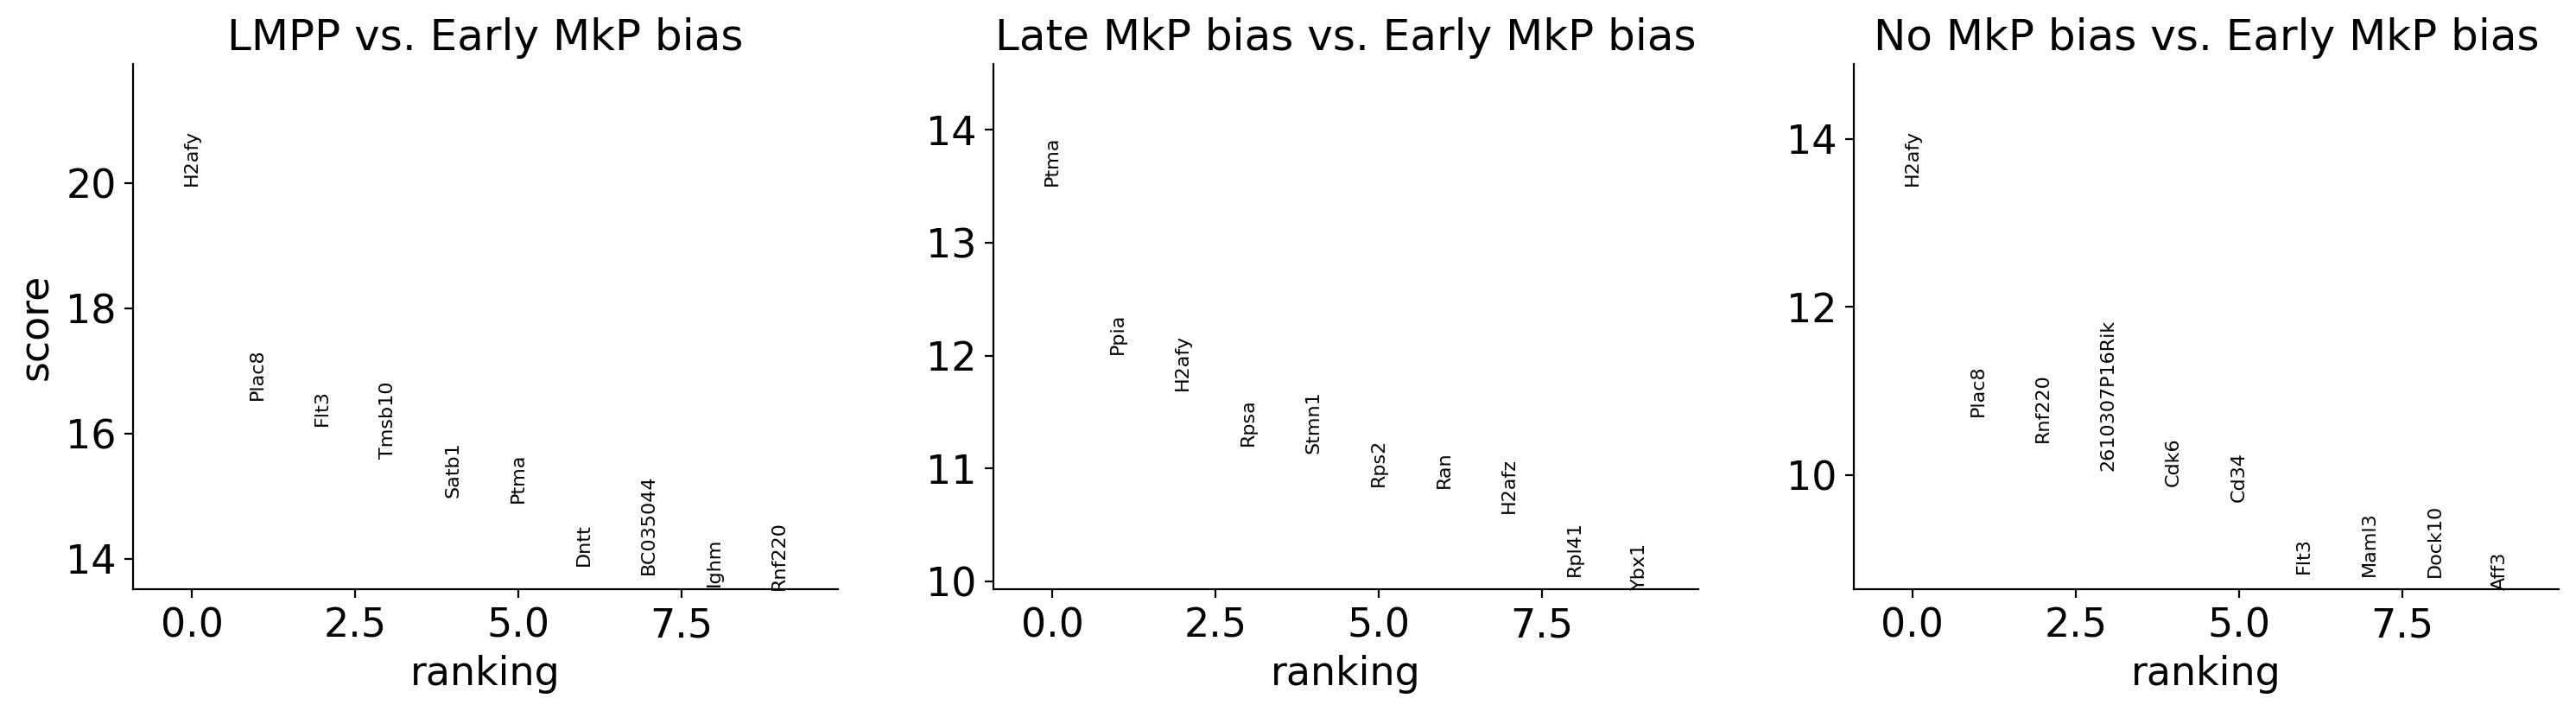

/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:798: RuntimeWarning: overflow encountered in expm1
  (expm1_func(mean_in_cluster) + 1e-9)
/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:799: RuntimeWarning: overflow encountered in expm1
  / (expm1_func(mean_out_cluster) + 1e-9)
/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:798: RuntimeWarning: invalid value encountered in divide
  (expm1_func(mean_in_cluster) + 1e-9)
/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:798: RuntimeWarning: overflow encountered in expm1
  (expm1_func(mean_in_cluster) + 1e-9)
/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:799: RuntimeWarning: overflow encountered in expm1
  / (expm1_func(mean_out_cluster) + 1e-9)
/home/shouwen

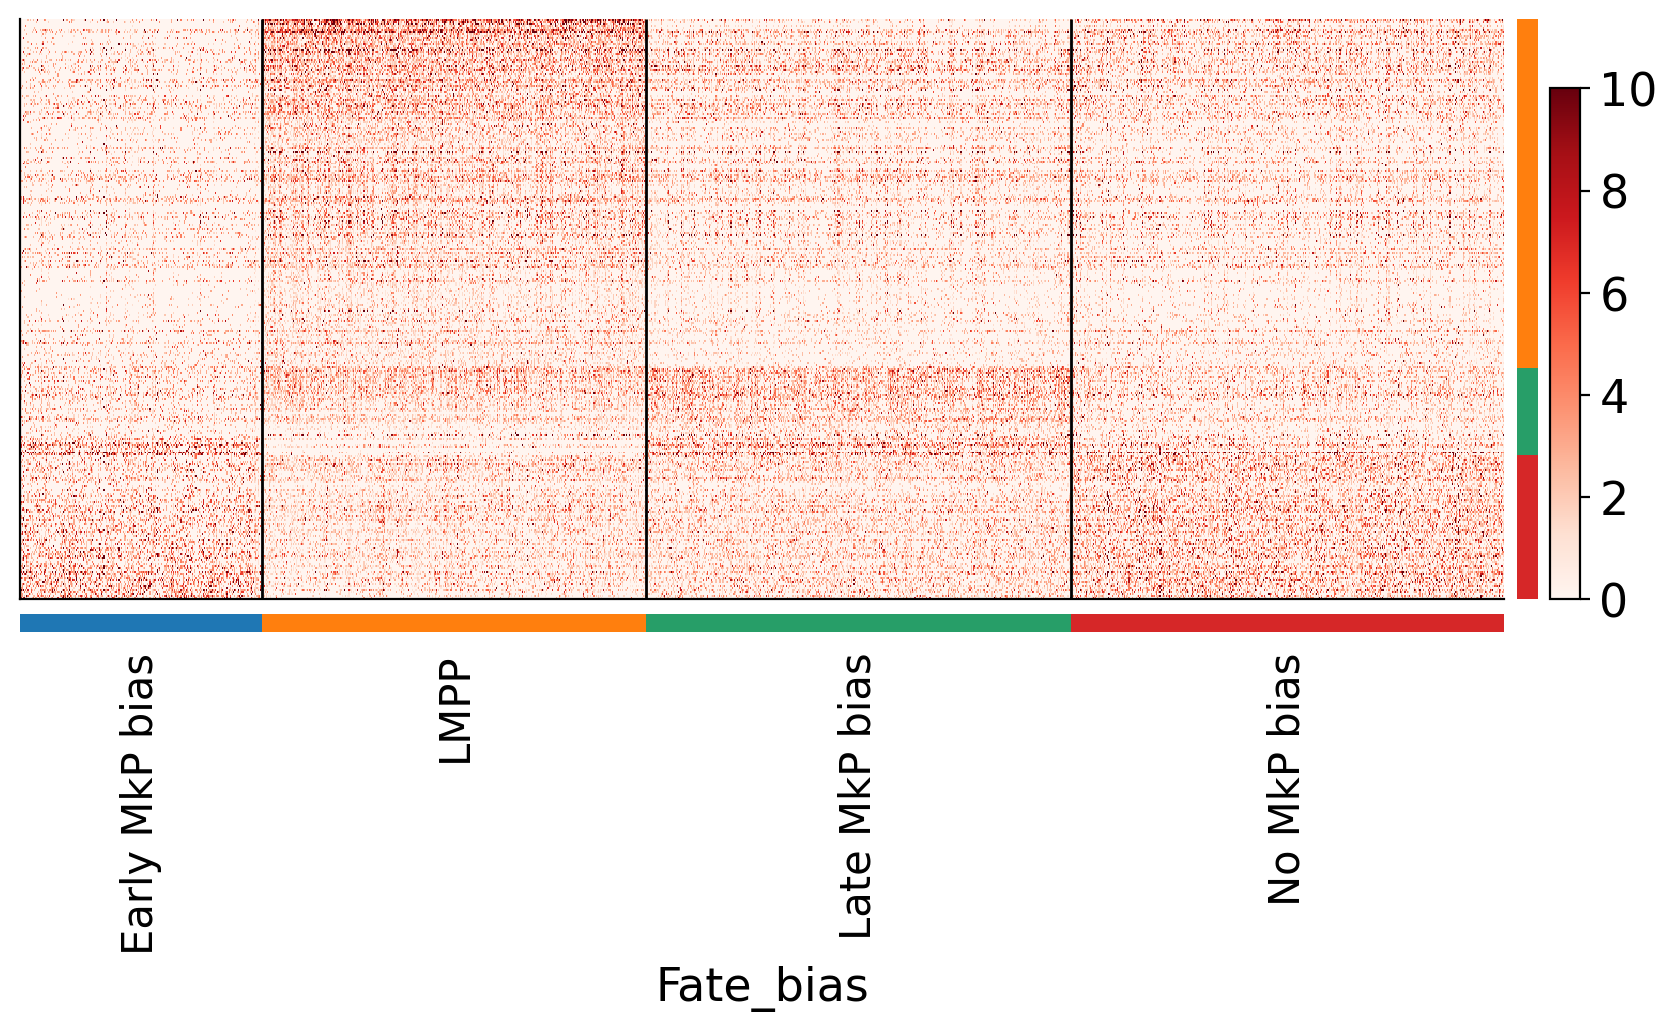

In [58]:
make_gene_heatmap=True
if make_gene_heatmap:
    sc.tl.rank_genes_groups(adata_sub, 'Fate_bias', method='wilcoxon',reference='Early MkP bias')
    sc.pl.rank_genes_groups(adata_sub, n_genes=10, sharey=False)

    adata_sub_1=adata_sub[~pd.isna(adata_sub.obs['Fate_bias'])]
    sc.tl.filter_rank_genes_groups(adata_sub_1)
    sc.pl.rank_genes_groups_heatmap(adata_sub_1, n_genes=200, key='rank_genes_groups_filtered',
                                    swap_axes=True, use_raw=False, vmax=10, vmin=0, cmap='Reds', dendrogram=False,save='gene_heatmap')

In [59]:
cluster_name='No MkP bias'
df_DGE=pd.DataFrame({'logfoldchanges':pd.DataFrame(adata_sub_1.uns['rank_genes_groups']['logfoldchanges'])[cluster_name],
'logpvalue': -np.log10(pd.DataFrame(adata_sub_1.uns['rank_genes_groups']['pvals_adj'])[cluster_name]),
'gene': pd.DataFrame(adata_sub_1.uns['rank_genes_groups']['names'])[cluster_name]})
                       

cluster_name='Late MkP bias'
df_DGE_1=pd.DataFrame({'logfoldchanges':pd.DataFrame(adata_sub_1.uns['rank_genes_groups']['logfoldchanges'])[cluster_name],
'logpvalue': -np.log10(pd.DataFrame(adata_sub_1.uns['rank_genes_groups']['pvals_adj'])[cluster_name]),
'gene': pd.DataFrame(adata_sub_1.uns['rank_genes_groups']['names'])[cluster_name]})

df_DGE_all=pd.concat([df_DGE,df_DGE_1],ignore_index=True)

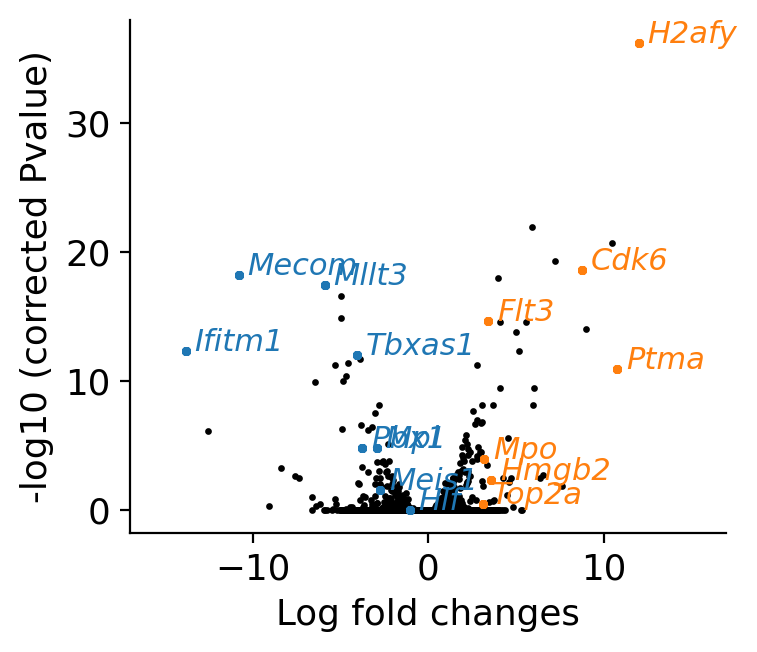

In [60]:
cs.settings.set_figure_params(pointsize=10)
fig,ax=plt.subplots(figsize=(4,3.5))
plt.scatter(df_DGE['logfoldchanges'],
            df_DGE['logpvalue'],
            s=2,color='k')
plt.xlim([-17,17])

DGE_genes_1=['Hlf','Mecom','Mpl','Mllt3','Tbxas1','Ifitm1',
                                 'Pbx1','Meis1',]
DGE_genes_2=['H2afy','Ptma','Cdk6','Mpo','Flt3','Hmgb2','Top2a']

# DGE_genes_1=df_DGE[(df_DGE['logfoldchanges']<0) & (df_DGE['logpvalue']>3)].assign(filter=lambda x: x['gene'].isin(highlighted)).query('filter==True')['gene'].to_list()
# DGE_genes_2=df_DGE[(df_DGE['logfoldchanges']>0) & (df_DGE['logpvalue']>3)].assign(filter=lambda x: x['gene'].isin(highlighted)).query('filter==True')['gene'].to_list()

for g in DGE_genes_1:
    color='#1f77b4'
    df_DGE_sel=df_DGE[df_DGE['gene'].isin(DGE_genes_1)]
    plt.scatter(df_DGE_sel['logfoldchanges'],
                df_DGE_sel['logpvalue'],
                s=5,color=color)

    tmp=df_DGE[df_DGE['gene']==g].values[0]
    ax.text(tmp[0]+0.5, tmp[1]+0, tmp[2],fontsize=11,color=color,style='italic')
    
for g in DGE_genes_2:
    color='#ff7f0e'
    df_DGE_sel=df_DGE[df_DGE['gene'].isin(DGE_genes_2)]
    plt.scatter(df_DGE_sel['logfoldchanges'],
                df_DGE_sel['logpvalue'],
                s=5,color=color)
    
    tmp=df_DGE[df_DGE['gene']==g].values[0]
    ax.text(tmp[0]+0.5, tmp[1]+0, tmp[2],fontsize=11,color=color,style='italic')

plt.xlabel('Log fold changes')
plt.ylabel('-log10 (corrected Pvalue)')
plt.tight_layout()
plt.savefig(f'{figure_path}/DGE_analysis_MkP.pdf')

/home/shouwen/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


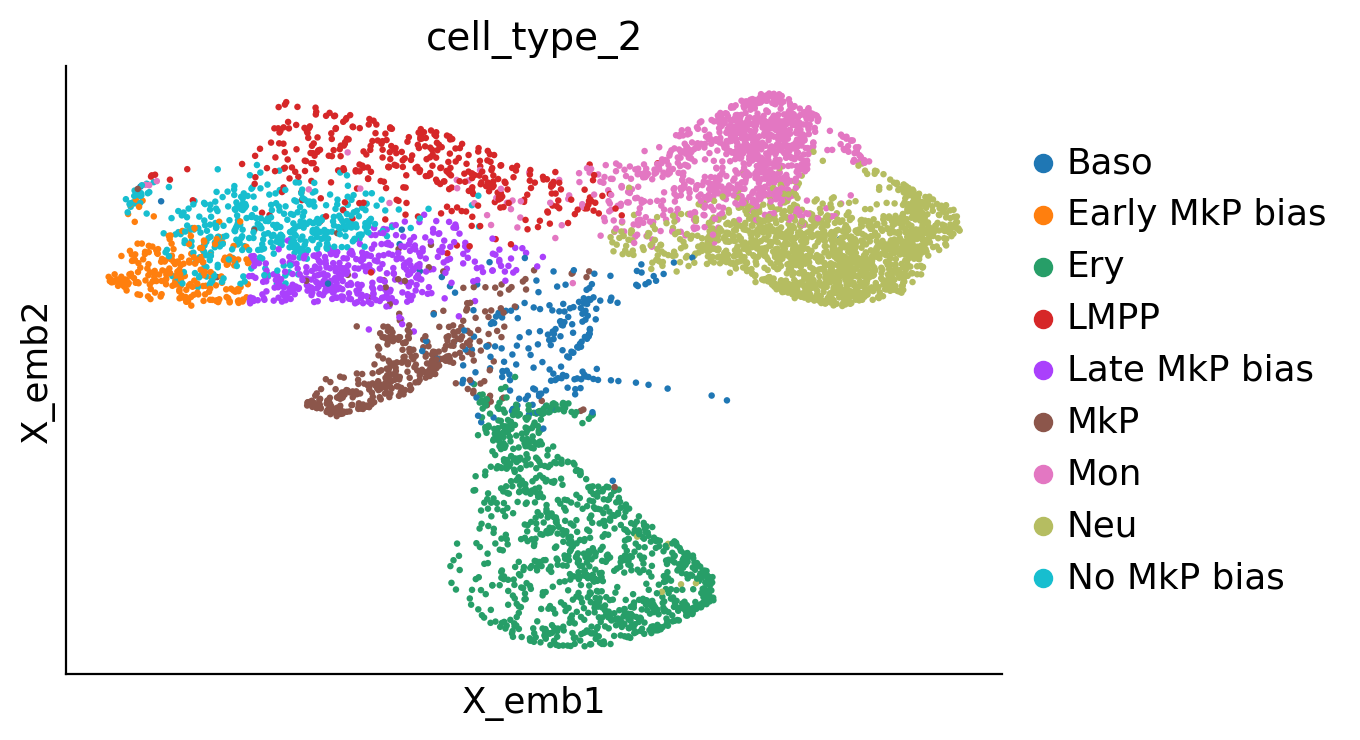

In [61]:
adata.obs['cell_type_2']=adata.obs['cell_type'].astype(str)
adata.obs.loc[adata.obs_names.isin(adata_sub.obs_names),'cell_type_2']=adata_sub.obs['Fate_bias']
cs.pl.embedding(adata,color='cell_type_2')

--> Using zscore (range: [-2,2], or [-1,1]


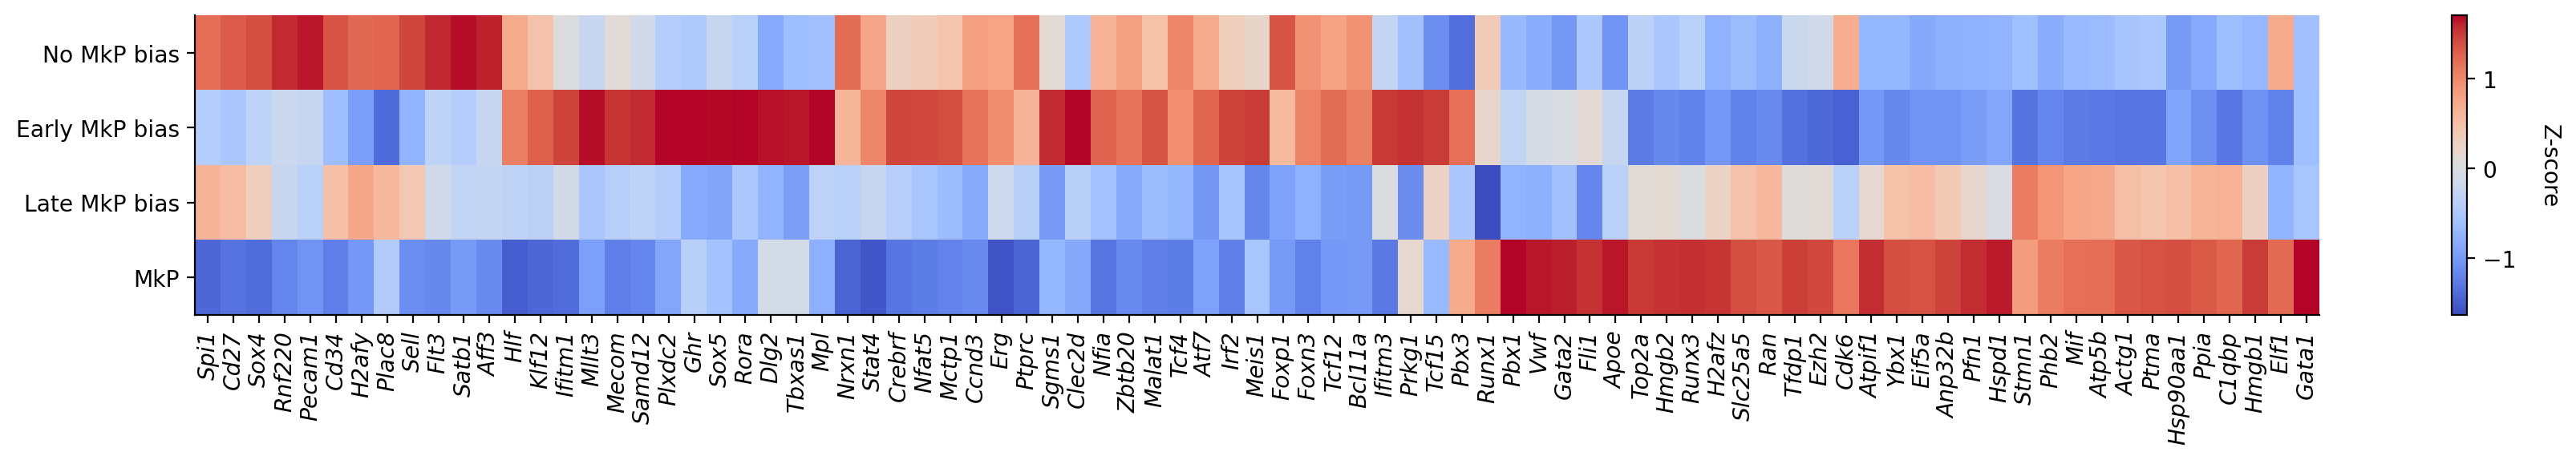

In [62]:
cs.settings.set_figure_params(fontsize=11)
cs.settings.verbosity=3
adata.obs['state_info']=adata.obs['cell_type_2']
# sel_genes=list(set(list(highlighted)+df_DGE_all[(df_DGE_all['logpvalue']>12)]['gene'].to_list()))
# sel_genes=[x for x in sel_genes if 'Rp' not in x]

sel_genes=[ 'Spi1','Cd27','Sox4','Rnf220','Pecam1','Cd34','H2afy','Plac8','Sell','Flt3','Satb1','Aff3', 'Hlf','Klf12','Ifitm1',
 'Mllt3','Mecom','Samd12','Plxdc2','Ghr','Sox5','Rora',
 'Dlg2', 'Tbxas1', 'Mpl', 'Nrxn1', 'Stat4', 'Crebrf',
       'Nfat5', 'Mctp1', 'Ccnd3', 'Erg', 'Ptprc', 'Sgms1', 'Clec2d',
       'Nfia', 'Zbtb20', 'Malat1', 'Tcf4', 'Atf7', 'Irf2', 'Meis1',
       'Foxp1', 'Foxn3', 'Tcf12', 'Bcl11a', 'Ifitm3',  'Prkg1',
       'Tcf15','Pbx3', 'Runx1',
'Pbx1','Vwf','Gata2','Fli1','Apoe','Top2a','Hmgb2','Runx3','H2afz','Slc25a5','Ran','Tfdp1','Ezh2',
 'Cdk6','Atpif1','Ybx1','Eif5a','Anp32b','Pfn1','Hspd1','Stmn1',
 'Phb2','Mif','Atp5b','Actg1','Ptma','Hsp90aa1','Ppia','C1qbp','Hmgb1','Elf1','Gata1']


matrix=cs.pl.gene_expression_heatmap(adata,selected_genes=sel_genes,
                              selected_fates=['No MkP bias', 'Early MkP bias','Late MkP bias','MkP'],
                             fig_width=18,fig_height=3,order_map_y=False,order_map_x=False,print_ordered_labels=False,method='zscore')
adata.obs['state_info']=adata.obs['cell_type']
plt.tight_layout()
plt.savefig(f'{figure_path}/DGE_analysis_MkP_heatmap.pdf')

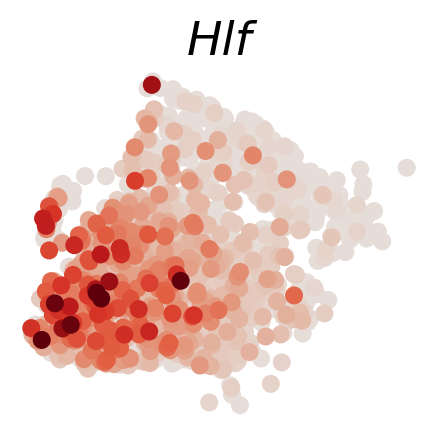

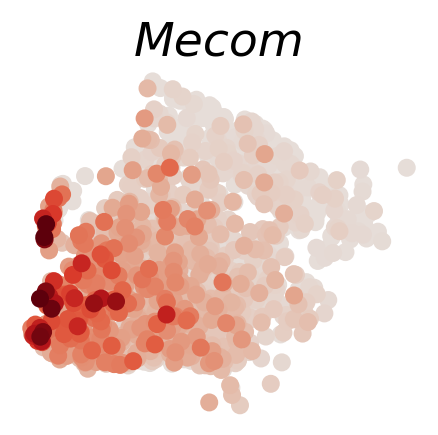

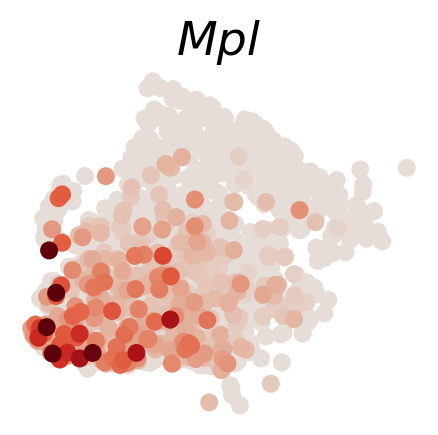

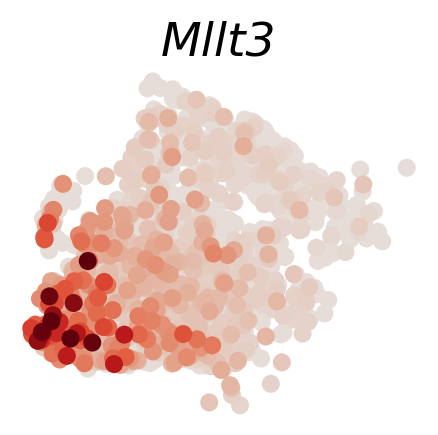

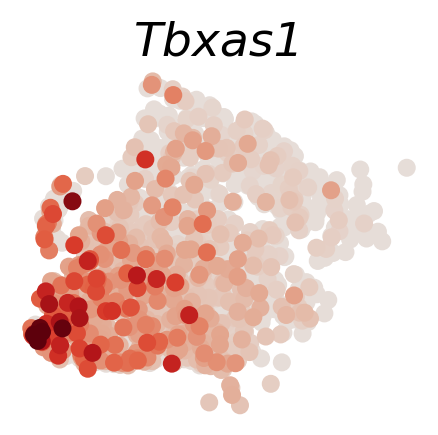

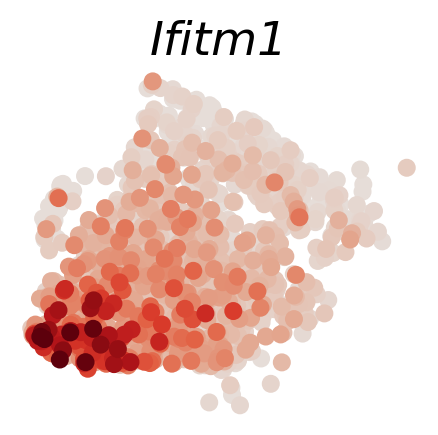

In [63]:
DGE_genes=['Hlf','Mecom','Mpl','Mllt3','Tbxas1','Ifitm1']
#DGE_genes=['Pbx1','Apoe']

cs.settings.set_figure_params(figsize=(2.5,2.5),pointsize=30,fontsize=17)
cs.pl.gene_expression_on_manifold(adata_sub,DGE_genes,savefig=True)

## Fate bias and pseudotime

Results saved at adata.obs['fate_map_transition_map_MkP']
Results saved at adata.obs['fate_map_transition_map_Ery_Neu_Mon_LMPP']
Results saved at adata.obs['fate_bias_transition_map_MkP*Ery_Neu_Mon_LMPP']


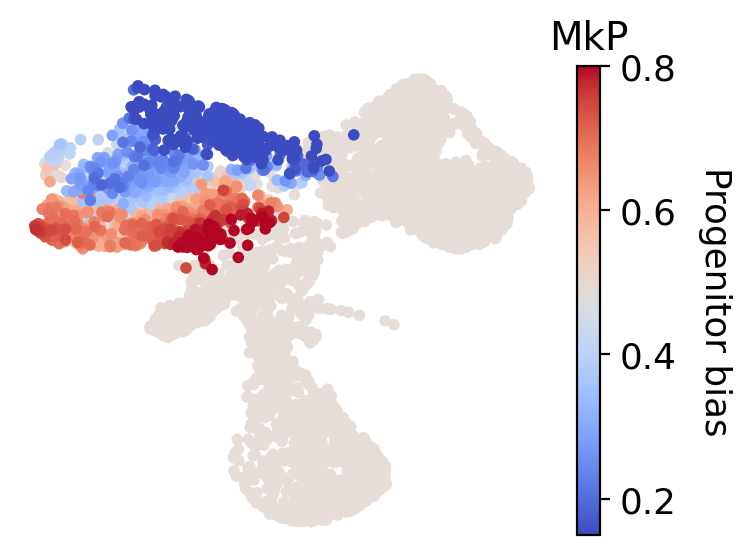

In [64]:
cs.settings.set_figure_params(figsize=(3,3),pointsize=10)
selected_fates=["MkP", ["Ery",'Neu','Mon','LMPP']]
cs.tl.fate_bias(
    adata,
    selected_fates=selected_fates,
    source="transition_map",
    pseudo_count=0,
)
cs.pl.fate_bias(
    adata,
    selected_fates=selected_fates,
    source="transition_map",
    plot_target_state=False,
    vmax=0.8,
    vmin=0.15,
)

Results saved at adata.obs['fate_map_transition_map_MkP']
Results saved at adata.obs['fate_map_transition_map_Ery_Neu_Mon_LMPP']
Results saved at adata.obs['fate_bias_transition_map_MkP*Ery_Neu_Mon_LMPP']
Results saved at adata.obs[f'progenitor_transition_map_MkP'] and adata.obs[f'diff_trajectory_transition_map_MkP']
Results saved at adata.obs[f'progenitor_transition_map_Ery_Neu_Mon_LMPP'] and adata.obs[f'diff_trajectory_transition_map_Ery_Neu_Mon_LMPP']


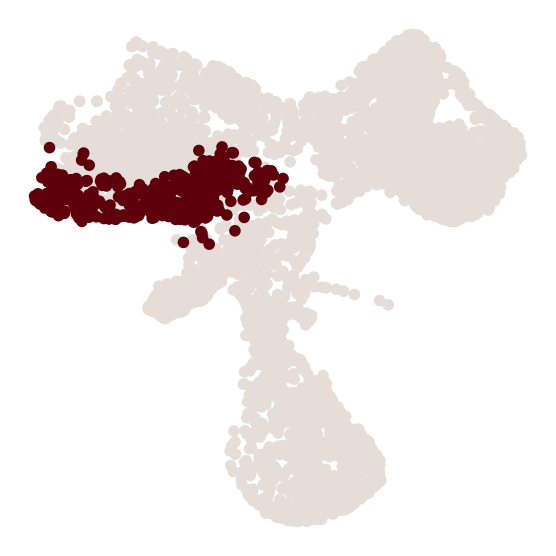

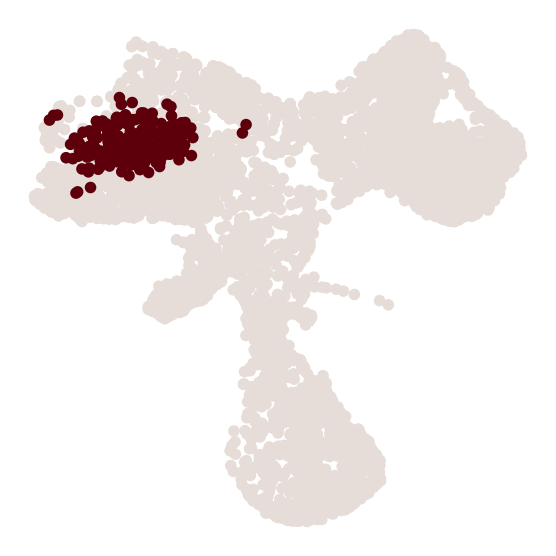

In [65]:
cs.tl.progenitor(
    adata,
    selected_fates=selected_fates,
    source="transition_map",
    map_backward=True,
    bias_threshold_A=0.6,
    bias_threshold_B=0.4,
    sum_fate_prob_thresh=0.2,
    avoid_target_states=True,
)
cs.pl.progenitor(
    adata, selected_fates=selected_fates, source="transition_map"
)

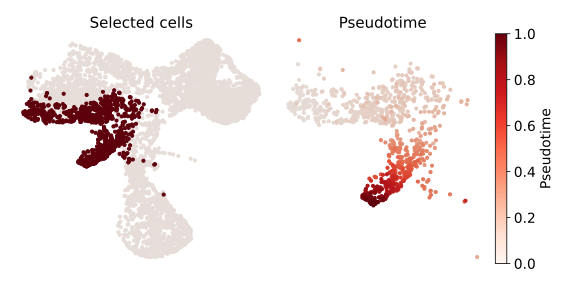

In [66]:
cs.settings.set_figure_params(figsize=(4,4),pointsize=10,fontsize=15)
gene_name_list = ['Mecom', "Vwf",'Mpl','Tbxas1','Ifitm1',
                                 'Meis1']
selected_fate = "MkP"
cs.pl.gene_expression_dynamics(
    adata,
    selected_fate,
    gene_name_list,
    traj_threshold=0.2,
    invert_PseudoTime=False,
    compute_new=True,
    gene_exp_percentile=99,
    n_neighbors=8,
    plot_raw_data=False,
    ggplot_font_size=17,
)